In [1]:
using Pkg

Pkg.activate("..")

using LinearAlgebra
using Distributions
using Random
using StatsBase

  Activating project at `~/Projects/Working/HIFMB/MiNet`
[ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]


In [2]:
using ForwardDiff
using LambertW
using Roots #some errorrs...

using Graphs
using CairoMakie

Precompiling DistributionsTestExt
  ✓ Distributions → DistributionsTestExt
  ✓ Distributions → DistributionsChainRulesCoreExt
  2 dependencies successfully precompiled in 11 seconds. 49 already precompiled.
[ Info: Precompiling DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019]
┌ Warning: Module Distributions with build ID fafbfcfd-14ad-ae33-0000-70853d0063c4 is missing from the cache.
│ This may mean Distributions [31c24e10-a181-5473-b8eb-7969acd0382f] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:1948
[ Info: Skipping precompilation since __precompile__(false). Importing DistributionsTestExt [ffbe0ea5-a612-5ff7-aaf5-cac02eef3019].
[ Info: Precompiling SpecialFunctionsChainRulesCoreExt [9eb7bdd4-e44c-55fc-b9cc-1a32cb715188]
Precompiling StatsFunsChainRulesCoreExt
  ✓ StatsFuns → StatsFunsChainRulesCoreExt
  1 dependency successfully precompiled in 5 seconds. 27 already precompiled.
[ Info: Precompiling StatsFunsChainRulesCoreExt [d

# Analytical 

In [3]:
#return zero solution in interval a - b
function bisection(f::Function, a::Float64, b::Float64, tol::Float64)
    
    if sign(f(a)) == sign(f(b))
        # error("function has the same sign at given endpoints")
        return(NaN)
    end

    mid = (a + b)/2

    while abs(f(mid)) > tol

        sign(f(mid)) == sign(f(a)) ? a=mid : b=mid
            
        mid = (a + b)/2

    end

    return mid
    
end

function newtons_method(f,df,x0, tol)
    #get derivative function
    r = f(x0) / df(x0)
    x0 = x0 - r
    k = 0
    # println(abs(r))
    while abs(r) > tol && k < 10
        k += 1
        r = f(x0) / df(x0)
        x0 = x0 - r 

        # println(abs(r) > tol, r)
    end

    return(k == 10 ? NaN : x0)
end

# #get proportion of surviving based on functions f and params p
#assumes no correlation and no 
fc(b::Float64,fB::Function,fC::Function) = 1 - fC(1 - b)
fb(b::Float64,fB::Function,fC::Function) = fB(1 - fC(1-b))

fb (generic function with 1 method)

In [467]:
#function takes joint generating functions and gives the solutions to the arrival probabilites
function arrival_prop_funcs(B::Function,C::Function,sb::Float64, sc::Float64)
    #get required functions
    #derivatives evaluated at 1
    dBY(X) = ForwardDiff.gradient(B, [X, 1.0])[2] #Ko * P(Ki,Ko) * X^Ki
    # dBX(Y) = ForwardDiff.gradient(B, [1.0, Y])[1] #Ki * P(Ki,Ko) * Y^Ko

    dCY(X) = ForwardDiff.gradient(C, [X, 1.0])[2]
    # dCX(Y) = ForwardDiff.gradient(C, [1.0, Y])[1]

    #arrival degree - normalised by mean
    B1_I(X) = dBY(X) / dBY(1.0) #Ko * P(Ki,Ko) * X^Ki / #Ko * P(Ki,Ko)
    C1_I(X) = dCY(X) / dCY(1.0)

    #actual probability functions
    fb(c1) = sb + B1_I(c1)*(1-sb)
    fc(b1) = 1 - C1_I(1-b1)*(1-sc)

    return Dict(:b => fb, :c => fc)
end

arrival_prop_funcs (generic function with 1 method)

In [1056]:
#solve for the arrival probability given the functions generated above
function solve_arrival_probs(B,C,sb,sc)
    f_sol = arrival_prop_funcs(B,C,sb,sc)
    
    x_vec = range(-0,1,length = 100)
    
    b1(x) = f_sol[:b](f_sol[:c](x)) - x
    b1_sols = find_zeros(b1, -0.0, 1.0)
    c1_sols = f_sol[:c].(b1_sols)
    b0_sols = [B([c, 1]) for c = c1_sols]
    c0_sols = [1 - C([1 - b, 1]) for b = b1_sols]

    return b0_sols, c0_sols
end

solve_arrival_probs (generic function with 1 method)

# Poisson distribution

In [1055]:
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

#generate p_list
n_l = 100
l_vec = range(0.01, 5.0, length = n_l)
ρ = 0.0
p_mat = [([λn,λp,ρ*sqrt(λn*λp)], [λp,λn,ρ*sqrt(λn*λp)]) for λn = l_vec, λp = l_vec]

b1_sols = Matrix{Vector}(undef,n_l, n_l)
c1_sols = similar(b1_sols)

b0_sols = similar(b1_sols)
c0_sols = similar(c1_sols)

k = [0]

@time Threads.@threads for i = 1:n_l
    for j = 1:n_l
        k[1] += 1
        print("\r", k)
        B(x) = F(x[1],x[2], p_mat[i,j][1])
        C(x) = F(x[1],x[2], p_mat[i,j][2])

        b0,c0 = solve_arrival_probs(B,C,0.0,0.0)
        
        # f_sol = arrival_prop_funcs(B,C,0.0,0.0)
        # x_vec = range(-0,1,length = 100)
        # b1(x) = f_sol[:b](f_sol[:c](x)) - x
        
        # b1_sols[i,j] = find_zeros(b1, -0.0, 1.0)
        # c1_sols[i,j] = f_sol[:c].(b1_sols[i,j])
    
        b0_sols[i,j] = b0 #[B([c, 1]) for c = c1_sols[i,j]]
        c0_sols[i,j] = c0 #[1 - C([1 - b, 1]) for b = b1_sols[i,j]]
    end
end

[9946] 21.484184 seconds (378.20 M allocations: 13.768 GiB, 16.43% gc time, 54.02% compilation time)


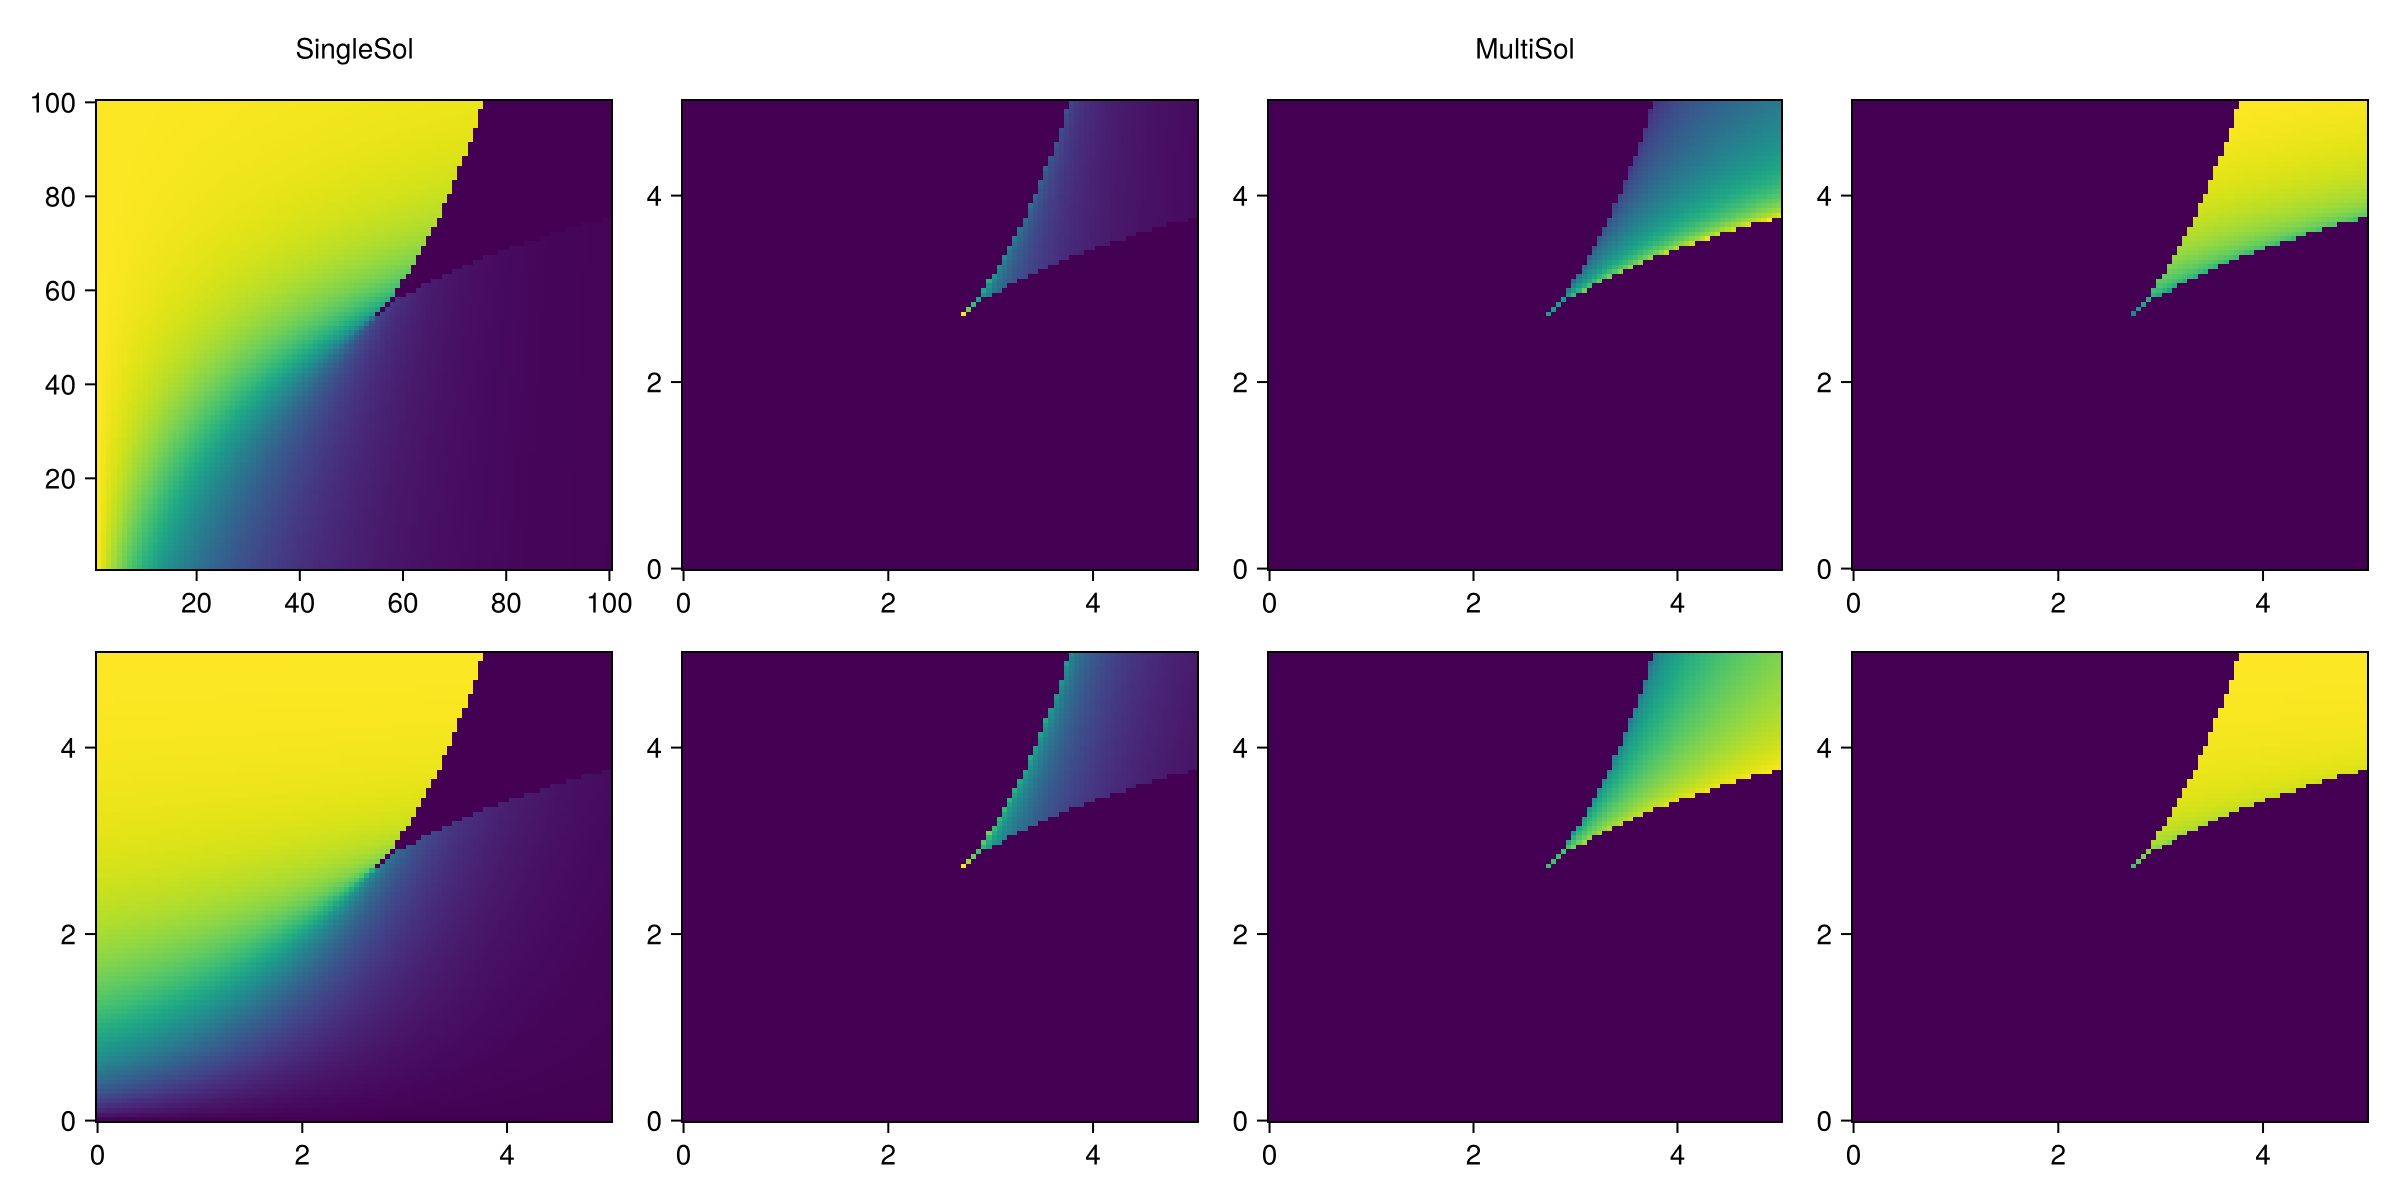

In [481]:
f = Figure(size = (1200,600))

Nb = length.(b0_sols)
b1 = [length(b) == 1 ? b[1] : 0 for b = b0_sols]
ax = Axis(f[1,1])
heatmap!(ax, b1)

b3 = [[length(b) == 3 ? b[i] : 0 for b = b0_sols] for i = 1:3]
ax_multi = [Axis(f[1, 1 + i]) for i = 1:3]
[heatmap!(ax_multi[i], l_vec, l_vec, b3[i]) for i = 1:3]

Nc = length.(c0_sols)
c1 = [length(c) == 1 ? c[1] : 0 for c = c0_sols]
ax = Axis(f[2,1])
heatmap!(ax, l_vec, l_vec, c1)

c3 = [[length(c) == 3 ? c[i] : 0 for c = c0_sols] for i = 1:3]
ax_multi = [Axis(f[2, 1 + i]) for i = 1:3]
[heatmap!(ax_multi[i], l_vec, l_vec, c3[i]) for i = 1:3]



Label(f[0,1],"SingleSol", tellwidth = false)
Label(f[0,2:4],"MultiSol", tellwidth = false)
f

# Supply

In [482]:
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))

#generate p_list
n_l = 100
s_vec = range(0.0, 1.0, length = n_l)
p_mat = [[s_vec[i],s_vec[j]] for i = 1:n_l, j=1:n_l]

b1_sols = Matrix{Vector}(undef,n_l, n_l)
c1_sols = similar(b1_sols)

b0_sols = similar(b1_sols)
c0_sols = similar(c1_sols)

λn, λp, ρ = [5.0,5.0,0.0]
r = 0.0 * sqrt(λn * λp)

k = [0]

@time Threads.@threads for i = 1:n_l
    for j = 1:n_l
        k[1] += 1
        print("\r", k, "  ")

        B(x) = F(x[1], x[2], [λn, λp, r])
        C(x) = F(x[1], x[2], [λp, λn, r])
    
        f_sol = arrival_prop_funcs(B,C,p_mat[i,j][1], p_mat[i,j][2])
        x_vec = range(-0,1,length = 100)
        b1(x) = f_sol[:b](f_sol[:c](x)) - x
    
        b1_sols[i,j] = find_zeros(b1, -0.0, 1.0)
        c1_sols[i,j] = f_sol[:c].(b1_sols[i,j])

        b0_sols[i,j] = [B([c, 1]) for c = c1_sols[i,j]]
        c0_sols[i,j] = [1 - C([1 - b, 1]) for b = b1_sols[i,j]]
    end
end

[9969]   26.782448 seconds (301.49 M allocations: 12.098 GiB, 13.24% gc time, 59.64% compilation time)


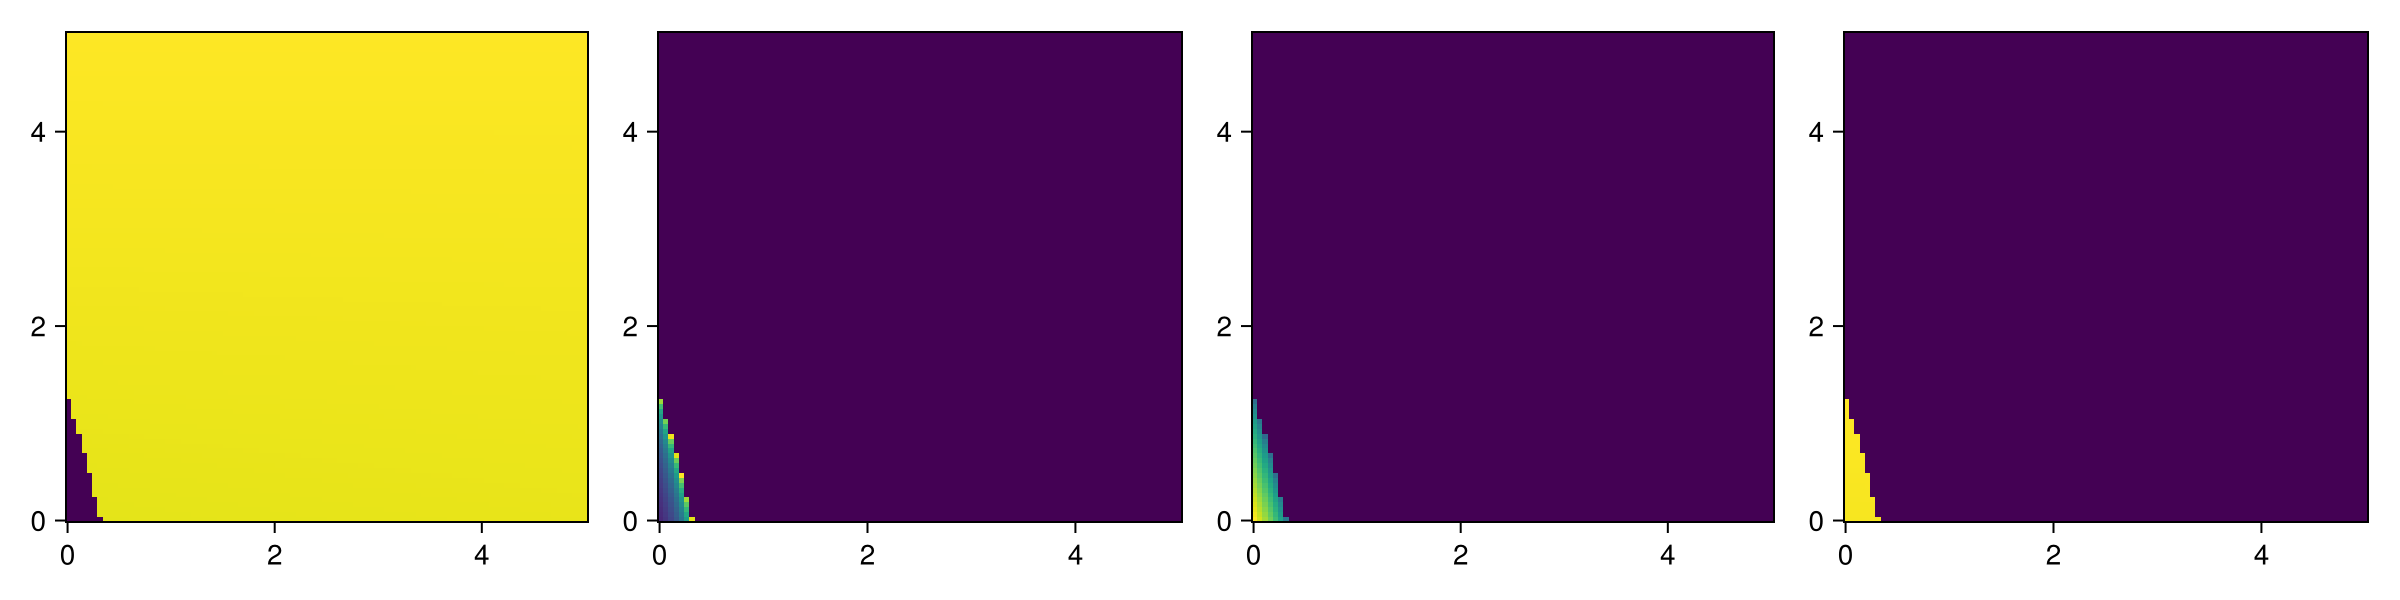

In [488]:
Nb = length.(b0_sols)

f = Figure(size = (1200,300))
b1 = [length(b) == 1 ? b[1] : 0 for b = b0_sols]
ax = Axis(f[1,1])
heatmap!(ax, l_vec, l_vec, b1)

b3 = [[length(b) == 3 ? b[i] : 0 for b = b0_sols] for i = 1:3]
ax_multi = [Axis(f[1, 1 + i]) for i = 1:3]
[heatmap!(ax_multi[i], l_vec, l_vec, b3[i]) for i = 1:3]

f

In [17]:
# f = Figure(size = (1200,600))

# Nb = length.(b0_sols)
# b1 = [length(b) == 1 ? b[1] : NaN for b = b0_sols]
# ax = Axis(f[1,1])
# heatmap!(ax, s_vec, s_vec, b1)

# b3 = [[length(b) == 3 ? b[i] : NaN for b = b0_sols] for i = 1:3]
# ax_multi = [Axis(f[1, 1 + i]) for i = 1:3]
# [heatmap!(ax_multi[i], s_vec, s_vec, b3[i]) for i = 1:3]

# Nc = length.(c0_sols)
# c1 = [length(c) == 1 ? c[1] : NaN for c = c0_sols]
# ax = Axis(f[2,1])
# heatmap!(ax, s_vec, s_vec, c1)

# c3 = [[length(c) == 3 ? c[i] : NaN for c = c0_sols] for i = 1:3]
# ax_multi = [Axis(f[2, 1 + i]) for i = 1:3]
# [heatmap!(ax_multi[i], s_vec, s_vec, c3[i]) for i = 1:3]

# Label(f[0,1],"SingleSol", tellwidth = false)
# Label(f[0,2:4],"MultiSol", tellwidth = false)
# f

# High Low Degree

In [494]:
# Two degree community
#generate p_list
n_l = 100
p_vec = range(0.0, 1.0, length = n_l)
f_two(x, p, k) = p[1,1]*x[1]*x[2] + p[2,1]*(x[1]^k * x[2]) + p[1,2]*(x[1] * x[2]^k) + p[2,2]*(x[1]^k * x[2]^k) 
 
p_mat = [[(1-i)*0.5 (1-i)*(0.5) ; (i)*0.5 (i)*(0.5)] for i = p_vec]

b1_sols = Matrix{Vector}(undef,n_l, n_l)
c1_sols = similar(b1_sols)

b0_sols = similar(b1_sols)
c0_sols = similar(c1_sols)

k = [0]
K = 2
@time Threads.@threads for i = 1:n_l
    for j = 1:n_l
        k[1] += 1
        print("\r", k)
        B(x) = f_two(x, p_mat[i], K)
        C(x) = f_two(x, p_mat[j], K)
    
        f_sol = arrival_prop_funcs(B,C,0.0,0.0)
        x_vec = range(-0,1,length = 100)
        b1(x) = f_sol[:b](f_sol[:c](x)) - x

        try
            b1_sols[i,j] = find_zeros(b1, 0.0, 1.0)
        catch
            b1_sols[i,j] = []
        end
        c1_sols[i,j] = f_sol[:c].(b1_sols[i,j])
    
        b0_sols[i,j] = [B([c, 1]) for c = c1_sols[i,j]]
        c0_sols[i,j] = [1 - C([1 - b, 1]) for b = b1_sols[i,j]]
    end
end

[9974] 13.480189 seconds (249.21 M allocations: 8.928 GiB, 13.81% gc time, 83.76% compilation time)


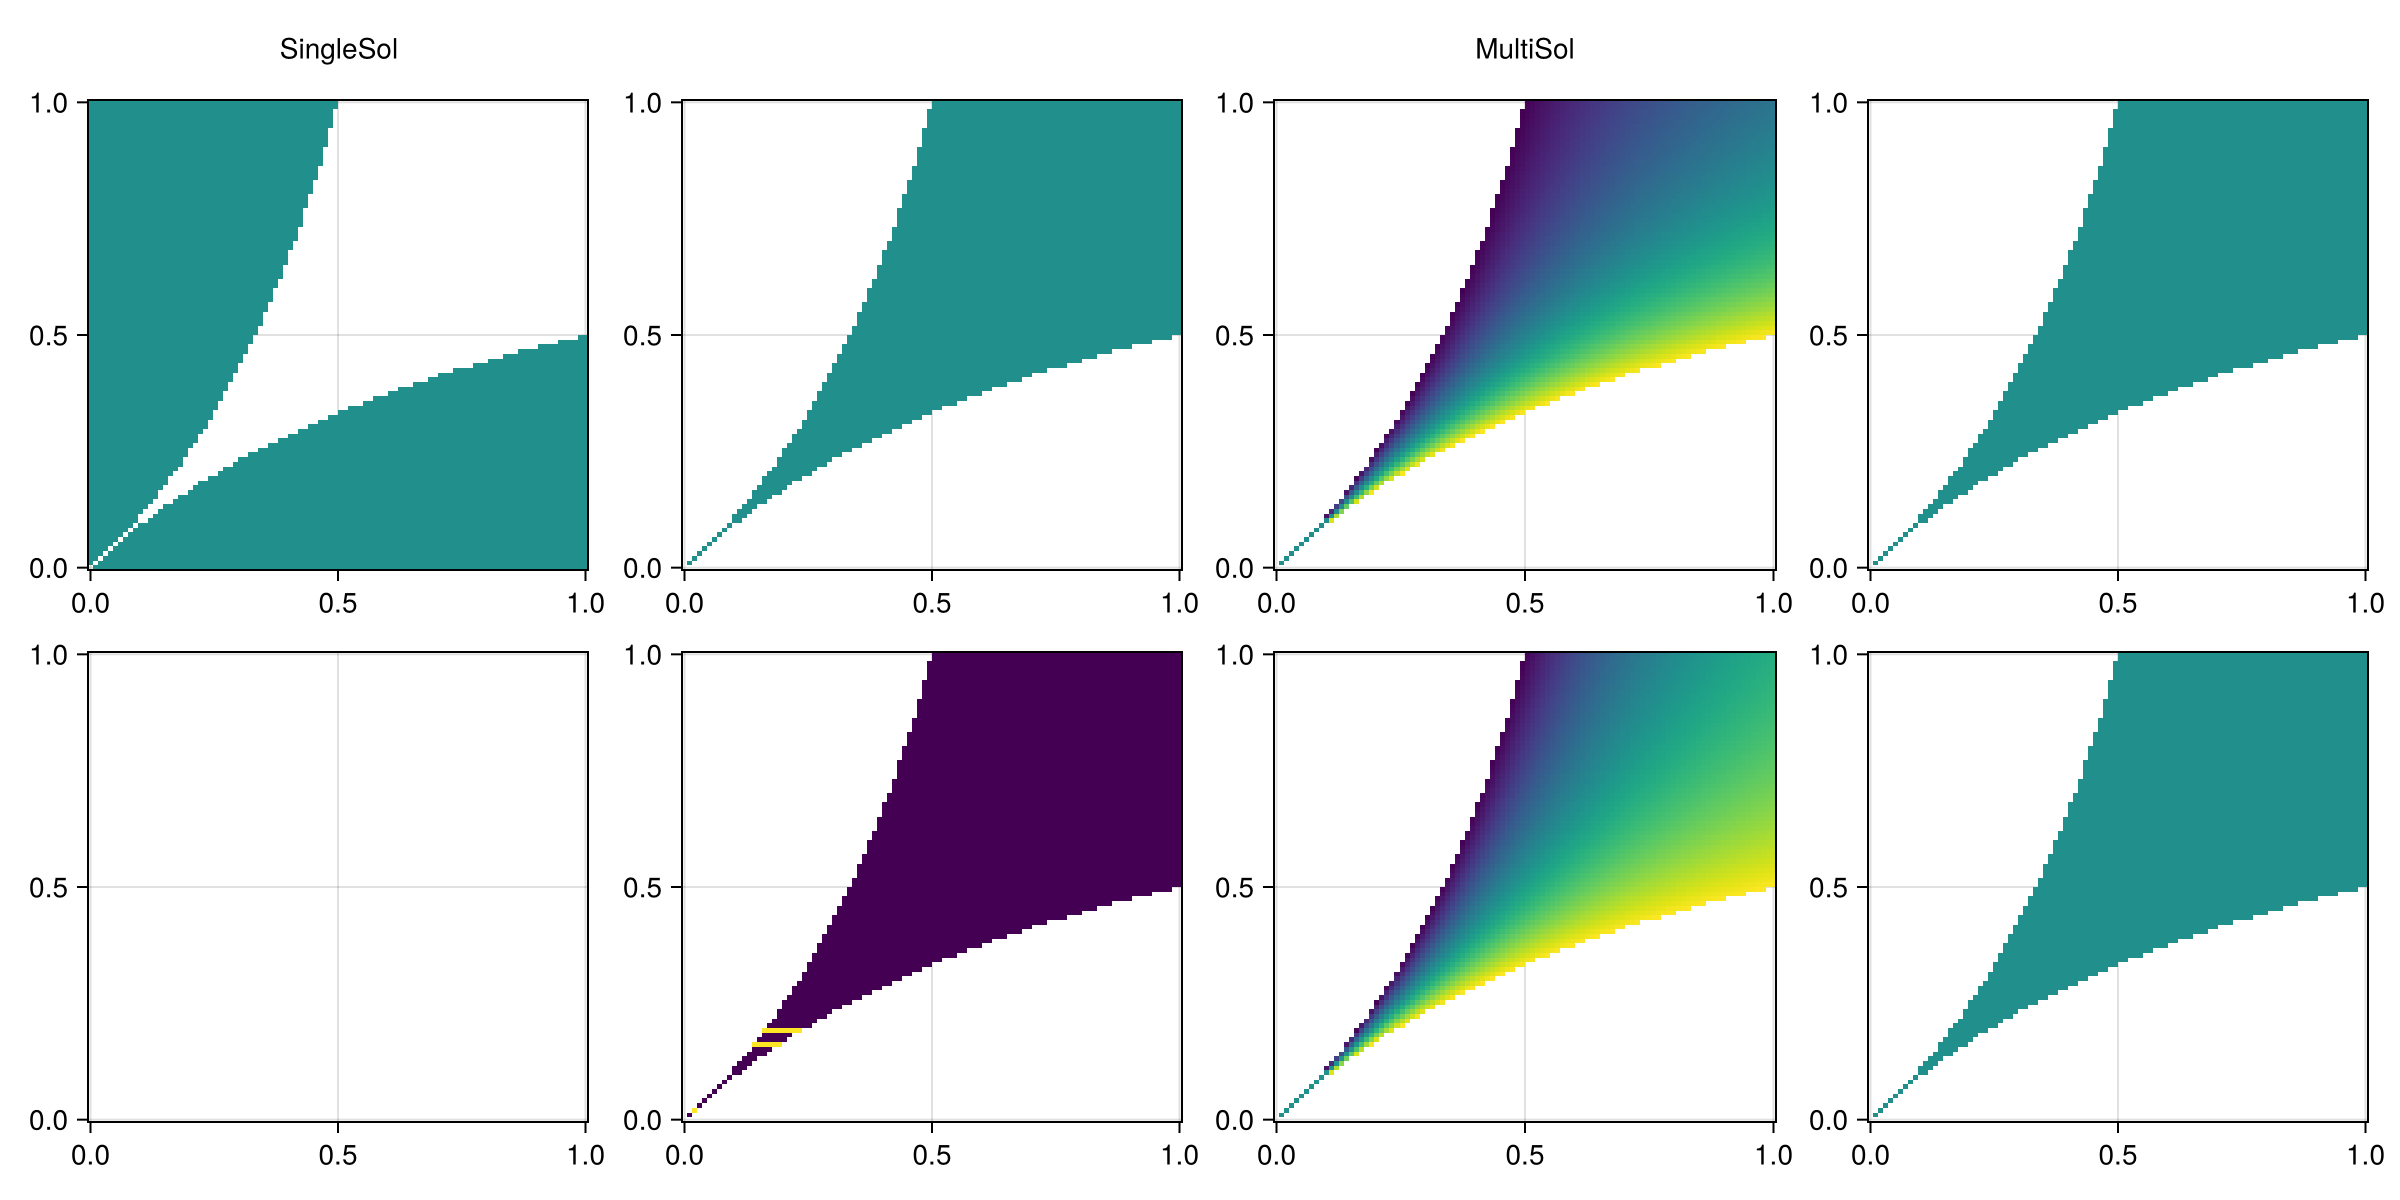

In [495]:
f = Figure(size = (1200,600))

Nb = length.(b0_sols)
b1 = [length(b) == 2 ? b[2] : NaN for b = b0_sols]
ax = Axis(f[1,1])
heatmap!(ax, p_vec, p_vec, b1)

b3 = [[length(b) == 3 ? b[i] : NaN for b = b0_sols] for i = 1:3]
ax_multi = [Axis(f[1, 1 + i]) for i = 1:3]
[heatmap!(ax_multi[i], p_vec, p_vec, b3[i]) for i = 1:3]

Nc = length.(c0_sols)
c1 = [length(c) == 1 ? c[1] : NaN for c = c0_sols]
ax = Axis(f[2,1])
heatmap!(ax, p_vec, p_vec, c1)

c3 = [[length(c) == 3 ? c[i] : NaN for c = c0_sols] for i = 1:3]
ax_multi = [Axis(f[2, 1 + i]) for i = 1:3]
[heatmap!(ax_multi[i], p_vec, p_vec, c3[i]) for i = 1:3]



Label(f[0,1],"SingleSol", tellwidth = false)
Label(f[0,2:4],"MultiSol", tellwidth = false)
f

# Network simulations

In [710]:
#sample degrees and maintain equality
function joint_sample(N,λn,λp,λr)
    #define distributions need + prod
    dK = [Poisson(λn + λr), Poisson(λp + λr)]
    #sample initial
    #need
    Kbi = rand(dK[1], N)
    Kco = rand(dK[1], N)
    #prod
    Kbo = rand(dK[2], N)
    Kci = rand(dK[2], N)

    #while loop
    n_eq, p_eq = 1,1
    
    while (n_eq != 0) || (p_eq != 0)
        if n_eq != 0
            #need
            Kbi[rand(1:N)] = rand(dK[1])
            Kco[rand(1:N)] = rand(dK[1])
        end

        if p_eq != 0
            #prod
            Kbo[rand(1:N)] = rand(dK[2])
            Kci[rand(1:N)] = rand(dK[2])
        end
        #eval
        n_eq = sum(Kbi) - sum(Kco)
        p_eq = sum(Kbo) - sum(Kci)
    end
    
    return(Kbi, Kbo, Kci, Kco)
end

function joint_sample_cheat(N,λn,λp,λr)
    #define distributions
    dK = [Poisson(λn + λr), 
          Poisson(λp + λr)]
    
    #sample need
    Kbi = rand(dK[1], N)
    Kco = shuffle(Kbi)
    
    #sample prod
    Kbo = rand(dK[2], N)
    Kci = shuffle(Kbo)
    
    return(Kbi, Kbo, Kci, Kco)
end

# generate bi-partite network
function generate_network(N,λn,λp,λr)
    Kbi, Kbo, Kci, Kco = joint_sample_cheat(N,λn,λp,λr)
    
    # println(mean(Kbi)," ",mean(Kco))
    # println(mean(Kbo)," ",mean(Kci))
    
    @assert sum(Kbi) == sum(Kco)
    @assert sum(Kbo) == sum(Kci)

    #assign graph
    g = DiGraph(2N)
    
    #get vertex need degree sequences
    begin
        vb_seq = inverse_rle(1:N, Kbi)
        vc_seq = inverse_rle((N+1):(2N), Kco)
        
        #permutate to create random pairs
        l_n = Pair.(shuffle(vc_seq), shuffle(vb_seq))
        add_edge!.(Ref(g), l_n)
    end
    
    #get vertex produce degree sequences
    begin
        vb_seq = inverse_rle(1:N, Kbo)
        vc_seq = inverse_rle((N+1):(2N), Kci)
        
        #permutate to create random pairs
        l_p = Pair.(shuffle(vb_seq), shuffle(vc_seq))
        add_edge!.(Ref(g), l_p)
    end
    return(g)
end

generate_network (generic function with 2 methods)

In [735]:
#dynamics
function update_state!(g,s,sfix = falses(nv(g)))
    for i = shuffle(1:nv(g))
            if sfix[i]
                s[i] = 0
            else
                # println(s)
                if i > N
                    # println("res")
                    @views s[i] = any(s[g.badjlist[i]])
                else
                    # println("con")
                    @views s[i] = all(s[g.badjlist[i]])
                end
            end
        end
end

function get_edges(g,s)
    [s[i.src] for i = edges(g)]
end

function get_p(x)
    [sum(x .== u) / length(x) for u = 0:maximum(x)]
end

get_p (generic function with 1 method)

In [744]:
function get_state(g,N,sb,sc)
    #inital state
    s = rand(2N) .< rand()
    # sfix = deepcopy(s)
    Nt = 100
    res = zeros(2,Nt)
    
    for i = 1:Nt
        update_state!(g, s)
        res[1,i] = mean(s[1:N])
        res[2,i] = mean(s[(N+1) : end])
    end
    
    return(s, res)
end

function get_props(s,N)
    return mean(s[1:N]), mean(s[N+1 : end])
end

get_props (generic function with 1 method)

In [745]:
#solve for the arrival probability given the functions generated above
function solve_arrival_probs(B,C,sb,sc)
    f_sol = arrival_prop_funcs(B,C,sb,sc)
    
    x_vec = range(-0,1,length = 100)
    
    b1(x) = f_sol[:b](f_sol[:c](x)) - x
    b1_sols = find_zeros(b1, -0.0, 1.0)
    c1_sols = f_sol[:c].(b1_sols)
    b0_sols = [B([c, 1]) for c = c1_sols]
    c0_sols = [1 - C([1 - b, 1]) for b = b1_sols]

    return b0_sols, c0_sols
end

solve_arrival_probs (generic function with 1 method)

In [935]:
N = 10000
#n p r
λn,λp,λr = 0.01, 3.0, 0.0

g = generate_network(N, λn,λp,λr);
@time s,res = get_state(g, N)

# #prediction
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))
B(x) = F(x[1],x[2], [λn,λp,λr])
C(x) = F(x[1],x[2], [λp,λn,λr])

pred_vals = solve_arrival_probs(B,C,0.0,0.0)

println("B sim:",sum(s[1:N])/N, "  ", pred_vals[1])
println("C sim:",sum(s[N+1 : end])/N, "  ", pred_vals[2])

  0.316932 seconds (1.95 M allocations: 45.687 MiB)
B sim:0.9989  [0.9995015084945905]
C sim:0.9477  [0.9501384206393955]


In [936]:
res = [get_state(g, N)[2] for i = 1:10];

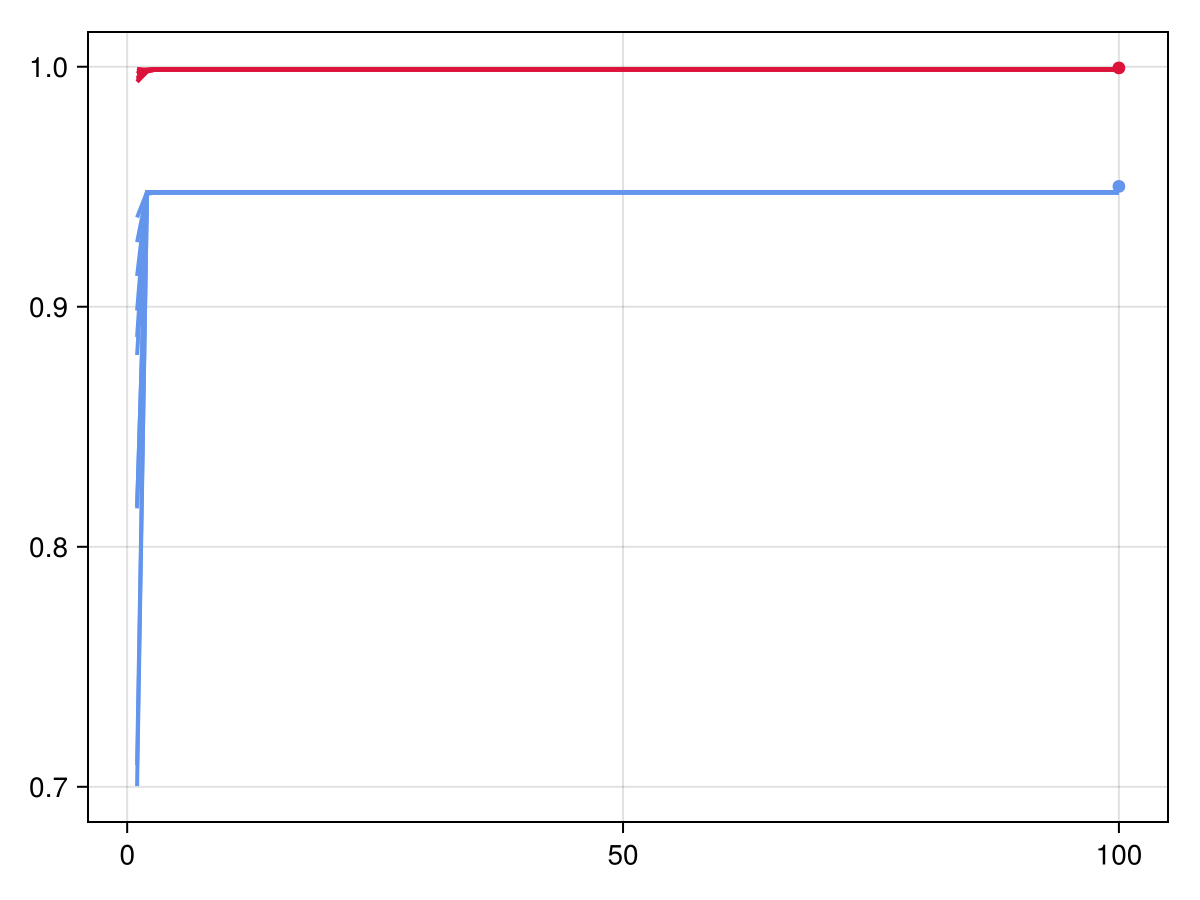

In [937]:
f = Figure()
ax = Axis(f[1,1])

[series!(ax, r, color = ["crimson","cornflowerblue"]) for r = res]
scatter!(ax, fill(100, length(pred_vals[1])) , pred_vals[1], color = "crimson")
scatter!(ax, fill(100, length(pred_vals[2])) , pred_vals[2], color = "cornflowerblue")

f

In [793]:
graphviz(g,s,N,"../Results/graphs/graph.tmp.dot", "../Results/Figures/graph.pdf")

Process(`dot -Tpdf ../Results/graphs/graph.tmp.dot`, ProcessExited(0))

In [1026]:
λc = 3.0

W0_vec = lambertw.(-1 ./ λc, 0)
W1_vec = lambertw.(-1 ./ λc, -1)

λb0 = -W0_vec / exp(1 / W0_vec)
λb1 = -W1_vec / exp(1 / W1_vec)

2.9295214273617938

In [1052]:
λp,λr = 3.0, 0.0

W0_vec = lambertw.(-1 ./ λc, 0)
W1_vec = lambertw.(-1 ./ λc, -1)

λb0 = -W0_vec / exp(1 / W0_vec)
λb1 = -W1_vec / exp(1 / W1_vec)


Nl = 50
l_vec = range(2.5,3.5,length = Nl)
l_vec = vcat(collect(l_vec), λb0, λb1) |> sort

N = 10000
Nsamp = 10
pred_mat = Array{Vector{Float64},2}(undef, length(l_vec), 2)
sim_mat  = Array{Float64,3}(undef, length(l_vec), 2, Nsamp)

k = [0]
Threads.@threads for l = eachindex(l_vec)
    k[1] += 1
    print("\r", k)
    λn = l_vec[l]
    
    g = generate_network(N,λn,λp,λr);
    for i = 1:Nsamp
        s,res = get_state(g, N)
    
        sim_mat[l,1,i] = mean(s[1:N])
        sim_mat[l,2,i] = mean(s[(N+1):end])
    end
    
    # #prediction
    F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))
    B(x) = F(x[1],x[2], [λn,λp,λr])
    C(x) = F(x[1],x[2], [λp,λn,λr])
    
    pred_vals = solve_arrival_probs(B,C,0.0,0.0)
    pred_mat[l,1] = pred_vals[1]
    pred_mat[l,2] = pred_vals[2]
end

[52]

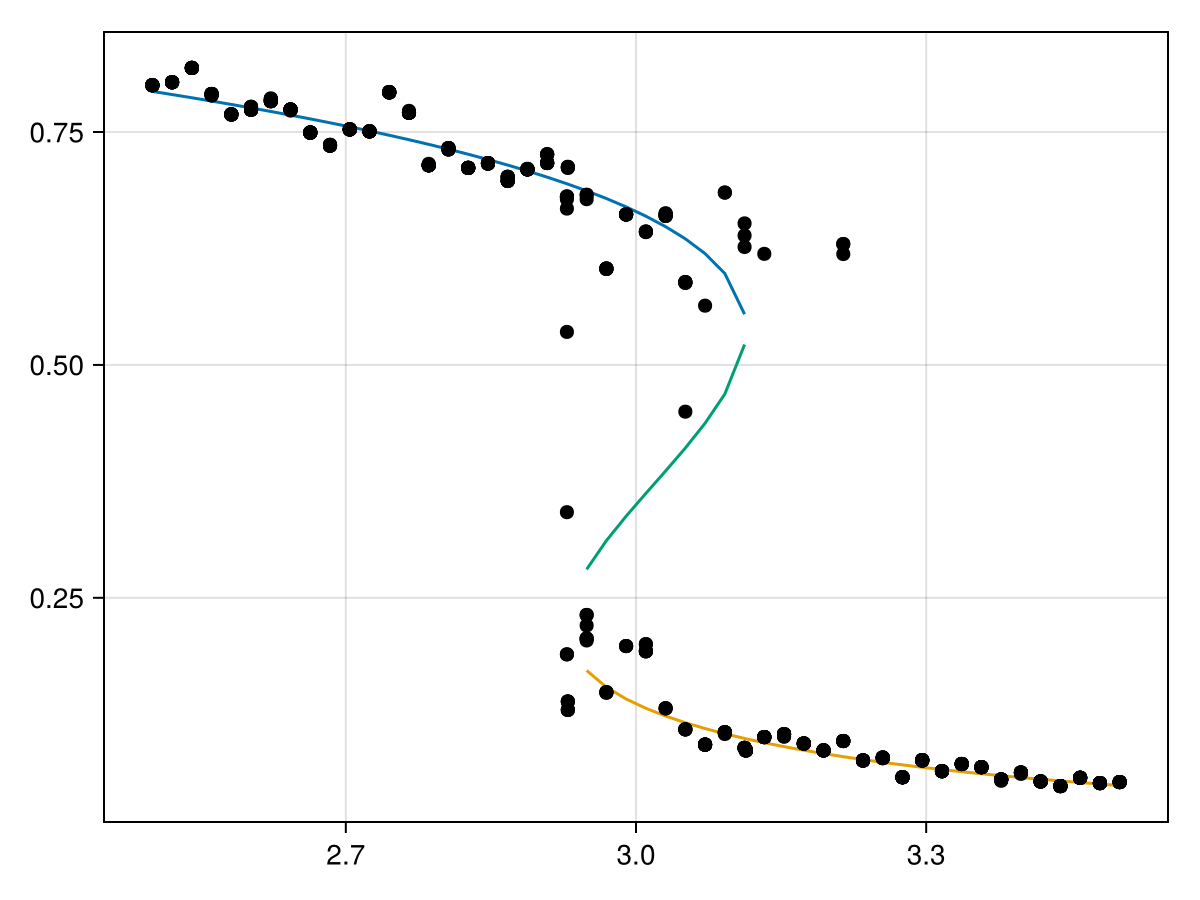

In [1053]:
f = Figure()
ax = Axis(f[1,1])

ind_start = findfirst(length.(pred_mat[:,1]) .== 3) 
ind_end = findlast(length.(pred_mat[:,1]) .== 3) 

#upper branch
ub = [maximum(pred_mat[i,1]) for i = 1:ind_end]
# #lower branch
lb = [minimum(pred_mat[i,1]) for i = ind_start : length(l_vec)]
#mid branch
mb = [pred_mat[i,1][2] for i = ind_start: ind_end]

lines!(ax, l_vec[1:ind_end], ub)
lines!(ax, l_vec[ind_start:length(l_vec)], lb)
lines!(ax, l_vec[ind_start: ind_end], mb)

for i = eachindex(l_vec)
    #sim
    y = sim_mat[i,1,:]
    x = fill(l_vec[i], length(y))
    # lb = quantile(y,0.05)
    # ub = quantile(y,0.95)
    # errorbars!(ax, [mean(x)],[mean(y)],[mean(y) - lb],[mean(y) - ub], color = "black")
    scatter!(ax, x ,y, markersize = 10, color = "black")
end

f

# Poisson Distribution

In [10]:
using Profile

Profile.clear()

In [30]:
#poisson
function f_test1(N_val = 10, Npoints = 100) 
    f_pois(x::Float64, p::Float64) = exp(p*(x - 1))
    
    # N_val = 10
    # Npoints = 100
    
    #param ranges
    λb_vec = range(0.01, 5.0, length = N_val)
    λc_vec = range(0.01, 5.0, length = N_val )
    x_vec = range(-0.0,1.0,length = Npoints)
    
    #results
    b_mat = Array{Vector{Float64}, 2}(undef, N_val,N_val)
    c_mat = similar(b_mat)
    val = similar(b_mat)
    
    k = [0]
    
    for i = eachindex(λb_vec)
        for j = eachindex(λc_vec)
            k[1] += 1
                fB(x::Float64) = f_pois(x,λb_vec[i])
                fC(x::Float64) = f_pois(x,λc_vec[j])
    
                f_opt(b::Float64) = fb(b, fB, fC) - b
                # df_opt(b) = ForwardDiff.derivative(f_opt, b)
                
                zeros = [bisection(f_opt, x_vec[i], x_vec[i+1], 1e-6) for i = 1:(Npoints-1)]
    
                b_mat[i,j] = zeros
                # c_mat[i,j] = fc.(filter(x -> x != -1, zeros), fB_pois, Ref(p))
        end
    end
    return b_mat
end



f_test1 (generic function with 3 methods)

In [38]:
@time f_test1(100,100)
@time f_test2(100,100)

  0.087818 seconds (10.01 k allocations: 8.774 MiB)
  0.073381 seconds (10.01 k allocations: 8.774 MiB)


100×100 Matrix{Vector{Float64}}:
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.990148]    …  [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.999933]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, 0.941917, NaN, NaN, NaN, NaN, NaN]       [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.999593]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]            [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.99925]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN]            [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, 0.998908]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  NaN, NaN, NaN

In [168]:
b_mat = map(x -> filter(y -> !isnan(y), x), b_mat);


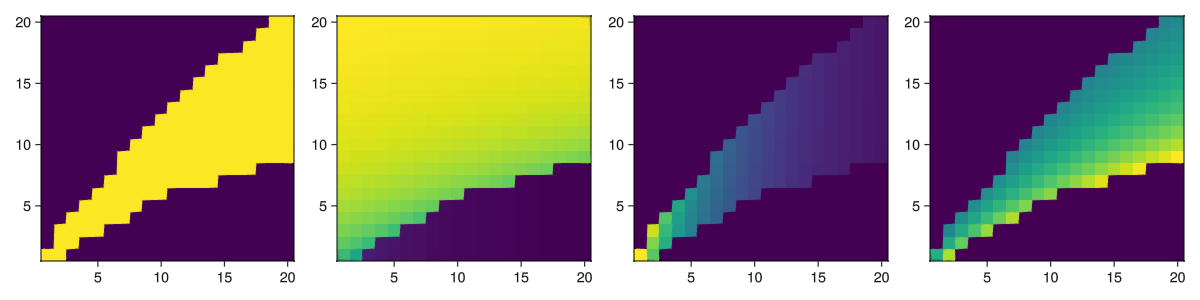

In [171]:
b_N = length.(b_mat)

b_1 = [length(b) == 1 ? b[1] : b[3] for b = b_mat]
b_2 = [length(b) == 1 ? 0 : b[1] for b = b_mat]
b_3 = [length(b) == 1 ? 0 : b[2] for b = b_mat]

f = Figure(size = (1200, 300))

[heatmap!(Axis(f[1,i]), b) for (i,b) = enumerate([b_N, b_1, b_2, b_3])]

f

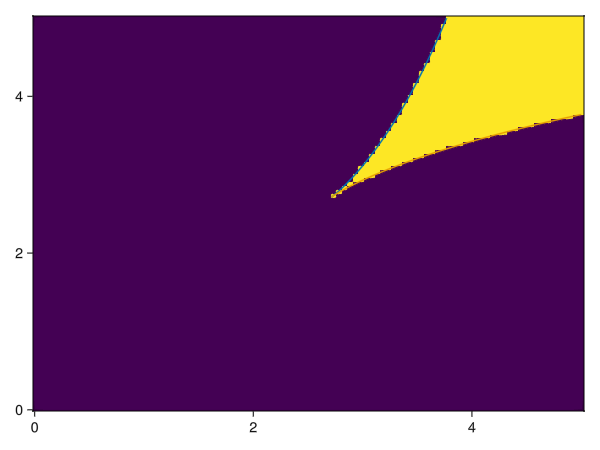

In [8]:
#Plot boundaries of solutions
λb_vec2 = range(ℯ ,5,length = 1000)
λc_vec2 = range(ℯ ,5,length = 1000)

function critical_points(λb, λc, v)
    W = lambertw(-1 / λc, v)
    l = log(1/(λb*λc))
    # W * l - W^2 - 1
    return( (1/(λb*λc))^W * (W/(-1/λc))^W)
end

RHS = exp(1)
tol = 2e-2
x = (abs.(critical_points.(λb_vec2, λc_vec2', 0) .- RHS )  .< tol) .| (abs.(critical_points.(λb_vec2, λc_vec2', -1) .- RHS) .< tol)

W0_vec = lambertw.(-1 ./ λc_vec2, 0)
W1_vec = lambertw.(-1 ./ λc_vec2, -1)

λb0 = -W0_vec ./ exp.(1 ./ W0_vec)
λb1 = -W1_vec ./ exp.(1 ./ W1_vec)

f = Figure()
ax = Axis(f[1,1])

b_mat_l = length.(b_mat)
heatmap!(ax, λb_vec, λc_vec, b_mat_l)

# ax = Axis(f[1,2])
# heatmap!(ax, λb_vec2, λc_vec2, x, colormap = :Greys, alpha = 0.4)

# x = (λc_vec' .* (λb_vec .+ 1)) .<= 1
# heatmap!(ax,λc_vec,λb_vec, x, colormap = :Greys, alpha = 0.4)

ind = λb0 .< 5

lines!(ax, λc_vec2[ind], λb0[ind])
lines!(ax, λc_vec2, λb1)


f

# Correlated Poisson

In [9]:
# Correlated Poisson
F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))
dF(X,λ) = (λ[1] + λ[3]*X) * exp(λ[2]*(X − 1)  + λ[3]*(X − 1)) / (λ[1] + λ[3])
#marginal distributions
F0_I(X,λ) = F(X,1,λ)
F0_O(Y,λ) = F(1,Y,λ)



#arrival degrees number of in degrees having arrived at out degree
function F1_I(X,λ)
    #vectorise function
    f(V) = F(V[1],V[2],λ)
    #take gradient wrt Y
    g = x -> ForwardDiff.gradient(f, x)[2]
    #return gradient at (X,1)
    return(g([X,1]) / g([1,1]))
end

#number of out having arrived at in
function F1_O(Y,λ)
    #vectorise function
    f(V) = F(V[1],V[2],λ)
    #take gradient wrt Y
    g = x -> ForwardDiff.gradient(f, x)[1]
    #return gradient at (X,1)
    return(g([1,Y]) / g([1,1]))
end

F1_O (generic function with 1 method)

In [121]:
#interactive plot
function get_solutions(ρ_b,ρ_c, s, Nvals = 25)
    Npoints = 10
    
    λn_vec = range(0.01, 5.0, length = Nvals)
    λp_vec = range(0.01, 5.0, length = Nvals)
    x_vec = range(-0.0,1.1,length = Npoints)
    #results
    b0_mat = Array{Vector{Float64}, 2}(undef, Nvals, Nvals)
    c0_mat = similar(b0_mat)
    
    b1_mat = Array{Vector{Float64}, 2}(undef, Nvals, Nvals)
    c1_mat = similar(b1_mat)
    
    Threads.@threads for i = eachindex(λn_vec)
        for j = eachindex(λp_vec)
                rb = ρ_b * sqrt(λn_vec[i] * λp_vec[j])
                rc = ρ_c * sqrt(λn_vec[i] * λp_vec[j])
                
                #parameter sets
                λb = [λn_vec[i] , λp_vec[j] , rb]
                λc = [λp_vec[j] , λn_vec[i] , rb]
                
                #effective functions
                B1_I(X) = F1_I(X, λb)
                C1_I(X) = F1_I(X, λc)
    
                #solve for b1
                f(b1) = B1_I((1 - C1_I(1-b1))) - b1
                zeros = [bisection(f, x_vec[v], x_vec[v+1], 1e-10) for v = 1:Npoints-1]
                
                b1_sols = filter(x -> x != -1, zeros)
                b1_mat[i,j] = b1_sols
                
                c1_sols = [(1 - C1_I(1 - b1)) for b1 = b1_sols]
                c1_mat[i,j] = c1_sols
    
                b0s = [F(c1,1,λb) for c1 = c1_sols]
                b0_mat[i,j] = b0s
    
                c0s = [1 - F(1 - b1,1,λc) for b1 = b1_sols]
                c0_mat[i,j] = c0s            
            end
        end
    return(b0_mat, c0_mat)
end

get_solutions (generic function with 3 methods)

In [122]:
x_vec = range(-2, 2, length = 100)
fig = Figure(size = (1200, 800))
sg = SliderGrid(
    fig[3, 1:4],
    (label = L"ρ_b", range = 0.0:0.001:1, format = "{:.1f}", startvalue = 0.0),
    (label = L"ρ_c", range = 0.0:0.001:1, format = "{:.1f}", startvalue = 0.0),
    (label = L"Nval", range = 0:1:50, format = "{:.1f}", startvalue = 25),
    width = 350,
    tellwidth = false)

sobs = [s.value for s in sg.sliders]

x = -1.0:0.01:1.0

vals = lift(sobs...) do y...
    get_solutions(y[1],y[2])
end

bN = lift(vals) do y
    length.(y[1])
end

b1 = lift(vals) do y
    b_1 = [length(b) == 1 ? b[1] : b[3] for b = y[1]]    
end

b2 = lift(vals) do y
    b_2 = [length(b) == 1 ? 0 : b[1] for b = y[1]]
end

b3 = lift(vals) do y
    b_3 = [length(b) == 1 ? 0 : b[2] for b = y[1]]
end

cN = lift(vals) do y
    length.(y[1])
end

c1 = lift(vals) do y
    c_1 = [length(c) == 1 ? c[1] : c[3] for c = y[2]]    
end

c2 = lift(vals) do y
    c_2 = [length(c) == 1 ? 0 : c[1] for c = y[2]]
end

c3 = lift(vals) do y
    c_3 = [length(c) == 1 ? 0 : c[2] for c = y[2]]
end


Observable(Real[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0.7281763279964042 0.7068456402845985; 0 0 … 0.7545888033118276 0.7346550668959151])


In [124]:
# λn_vec = range(0.01, 5.0, length = 30)
# λp_vec = range(0.01, 5.0, length = 30)

ax = [Axis(fig[1,i]) for i = 1:4]
[heatmap!(ax[i], [bN,b1,b2,b3][i]) for i = 1:4]

ax = [Axis(fig[2,i]) for i = 1:4]
[heatmap!(ax[i], [cN,c1,c2,c3][i]) for i = 1:4]

display(fig)

GLMakie.Screen(...)

In [17]:
# Fixed degrees
Fk(X, p, k) = p * X + (1-p) * X^k

N_val = 100
Npoints = 200

#param ranges
pb_vec = range(0.0,0.99, length = N_val)
pc_vec = range(0.0,0.99, length = N_val)
x_vec = range(-0.0,1.1,length = Npoints)

#results
b_mat = Array{Vector{Float64}, 2}(undef, N_val,N_val)
c_mat = similar(b_mat)
val = similar(b_mat)

k = [0]
Threads.@threads for i = eachindex(pb_vec)
    k[1] += 1
    print("\r", k)
    for j = eachindex(pc_vec)
            fB(x) = Fk(x, pb_vec[i], 1)
            fC(x) = Fk(x, pc_vec[j], 1)

            f_opt(b) = fb(b, fB, fC) - b
            
            zeros = [bisection(f_opt, x_vec[i], x_vec[i+1], 1e-10) for i = 1:Npoints-1]

            b_mat[i,j] = zeros
            # c_mat[i,j] = fc.(filter(x -> x != -1, zeros), fB_pois, Ref(p))
    end
end

b_mat = map(x -> filter(y -> y != -1, x), b_mat);


[100]

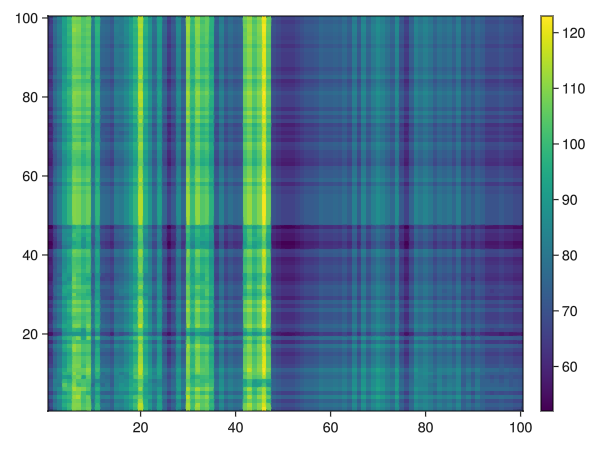

In [18]:
Nb = length.(b_mat)

f,ax = plot(Nb)
Colorbar(f[1,2], colorrange = (minimum(Nb),maximum(Nb)) )

f

6.99414
7.89273


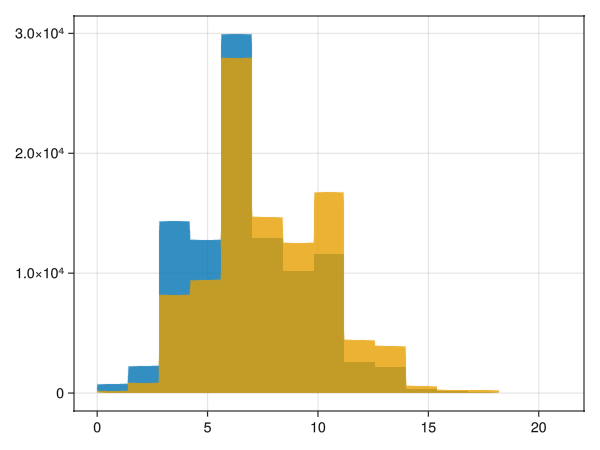

In [99]:
N = 100000
λ = [2.0,0.5,5.0]	

X = rand(Poisson(λ[1]), N) 
Y = rand(Poisson(λ[2]), N) 
Z = rand(Poisson(λ[3]), N) 

I = X + Z
O = Y + Z

#incoming given we arrived
ind = sample(1:100000, Weights(O), 100000)

f,ax = hist(I)
hist!(ax, I[ind])

println(mean(I))
println(mean(I[ind]))

f

In [104]:
sup = 0:50

px = [sum(X .== i) / N for i = sup]
py = [sum(Y .== i) / N for i = sup]

sum(px .* sup)

2.00082

In [111]:
py

51-element Vector{Float64}:
 0.60583
 0.30549
 0.07439
 0.01252
 0.00161
 0.00013
 3.0e-5
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [110]:
sum(py .* px)

0.9999999999999999

In [100]:
X .== 1


100000-element Vector{Int64}:
 1
 1
 0
 1
 1
 4
 1
 1
 0
 5
 2
 3
 2
 ⋮
 1
 1
 1
 1
 1
 3
 3
 2
 1
 2
 4
 4

In [93]:
((λ[1] + λ[3]) * (λ[2] + λ[3]) + λ[3]) / (λ[2] + λ[3])

7.909090909090909

In [61]:
n = 0
for (i,j) = p_unique
    n += p_mat[i+1,j+1] * i * j 
end
n

43.67460000000003

In [67]:
mean(I .* O)

43.6746

In [627]:
#explicit
# pi_o = p[:,ko + 1] / po[ko + 1]
v_ = zeros(3)

for ki = 1:3
    pki_o = p[ki, 2] / po[2] #prob consumer has ki given ko = 1
    a = zeros(3)
    for ko = 1:3
        a[ko] = qo[ko] * (ko-1) * pc_o[ko] #prob we arrive at resource degree ko
    end 
    ext = sum(a) ^ ki #prob all ki nodes are extant
    v_[ki] = ext  #prob node has ki and has all resources extant
end

v_

3-element Vector{Float64}:
 0.54
 0.2916
 0.15746400000000002

In [626]:
sum(v_)

0.9890640000000002

In [523]:
r_sample = sample(v, Weights((q .*  in_)[:]), 1000) 
[r[2] for r = r_sample]

1000-element Vector{Int64}:
 2
 1
 0
 1
 0
 0
 0
 2
 1
 2
 2
 1
 0
 ⋮
 2
 2
 1
 1
 0
 0
 2
 2
 0
 2
 1
 1

In [516]:
function normalise(x)
    u = unique(x) |> sort
    sum.([x .== u_ for u_ = u]) / length(x)
end

2-element Vector{Float64}:
 0.75
 0.25

In [70]:
pO = sum(p, dims = 1)[:]
pI_O = p ./ pO'
# N=2000
o = sample(1:3, Weights(pO), N)
i = [sample(1:3, Weights(pI_O[:,i])) for i = o]

s = [[a-1,b-1] for (a,b) = zip(i,o)]
u = unique(s) 

pn=zeros(3,3)

[pn[(u .+ 1)...] = sum(s .== Ref(u))/N for u = u]

pn

3×3 Matrix{Float64}:
 0.106   0.1085  0.096
 0.097   0.1915  0.0
 0.0995  0.0     0.3015

In [14]:
N = 2000
s = sample(v, Weights(p[:]), N);

0.16666666666666669

In [468]:
N = 2000
s = sample(v, Weights(p[:]), N);

Nin = sum([v[1] for v = s])
Nout = sum([v[2] for v = s])

while Nin != Nout
    s[rand(1:N)] = sample(v, Weights(p[:]))
    Nin = sum([v[1] for v = s])
    Nout = sum([v[2] for v = s])
end

In [469]:
gr = DiGraph()
add_vertices!(gr,N)

kin = [s[1] for s = s]
kout = [s[2] for s = s]

#add links
for i = 1:N
    #get current avalible in degree
    curr_kin = kin .- indegree(gr)
    ava = findall(curr_kin .> 0)
    j = sample(ava, kout[i], replace = false)
    if !isempty(j)
        add_edge!.(Ref(gr), i, j)
    end
end 

In [470]:
n = neighbors.(Ref(gr), 1:N)

k1 = length.(n)
k2 = [length.(neighbors.(Ref(gr), n)) |> sum for n = n];

In [478]:
[length(k1[k1 .== u]) for u = sort(unique(k1))] ./ N

3-element Vector{Float64}:
 0.213
 0.1925
 0.5945

In [479]:
sum(p, dims = 1)[:]

3-element Vector{Float64}:
 0.2
 0.2
 0.6

In [483]:
sum(k2) ./ N

2.1445

2024-08-01 08:11:36.132 julia[49258:2537073] AdjustToIronwoodHotKeyChange - CG (hotmod:1) HotKey : hotKey enabled = 1, keyChar=0xfffbffff, virtKey=0x40000, flags=0x0 


In [240]:
#prob of selecting out link k
sum(p, dims = 1)

1×2 Matrix{Float64}:
 0.2  0.8

In [247]:
so = [i[2] for i = s]
so1 = (sum(so) / N)
so0 = 1 - so1

[so0, so1]

2-element Vector{Float64}:
 0.20108000000000004
 0.79892

In [248]:
[p_sampled[i,j] * i *  j for i = 1:2, j = 1:2]

2×2 Matrix{Float64}:
 0.0      0.20004
 0.20108  0.59888

In [216]:
#numerics

N = 1000
M = 1001

λ = 1.0

pb = λ / (N)
pc = λ / (M)

# requirement links
B = rand(M,N) .< pb
Bl = Vector{Pair{Int,Int}}(undef, sum(B))
# production links
C = rand(N,M) .< pc
Cl = Vector{Pair{Int,Int}}(undef, sum(C))

#create sparse representation
kb,kc = 1,1
for i = 1:N
    for j = 1:M
        if B[j,i] == 1 # if i needs j
            Bl[kb] = (i => (j + N))
            kb += 1
        end

        if C[i,j] == 1 # if j made by j
            Cl[kc] = ((j + N) => i)
            kc += 1
        end

    end
end


In [217]:
E = vcat(Bl,Cl)
V = collect(1:(N+M))

g = DiGraph()

add_vertices!(g, N+M)
[add_edge!(g, i, j) for (i,j) = E];

#remove isolated consumers
iso = filter(x -> x <= N, findall((degree(g) .== 0)))

g_orginal = deepcopy(g)

{2001, 2054} directed simple Int64 graph

In [218]:
#calculate extant
#get degrees

Nn = nv(g) - M
dN = 1
while dN > 0
    k = indegree(g)
    kb = k[1:Nn]
    kc = k[Nn+1 : end]
    
    # # #get zero degree resources
    kc0 = findall(kc .== 0)
    println(length(kc0))
    
    # # #get consumer neighbours
    rm = vcat(neighbors.(Ref(g), kc0)...)
    
    rem_vertices!(g, rm)

    dN = Nn - (nv(g) - M)
    Nn = nv(g) - M
end

g_iso = findall(degree(g) .== 0)
gO_iso = findall(degree(g_orginal) .== 0);

371
520
666
743
773
781
784
789
790


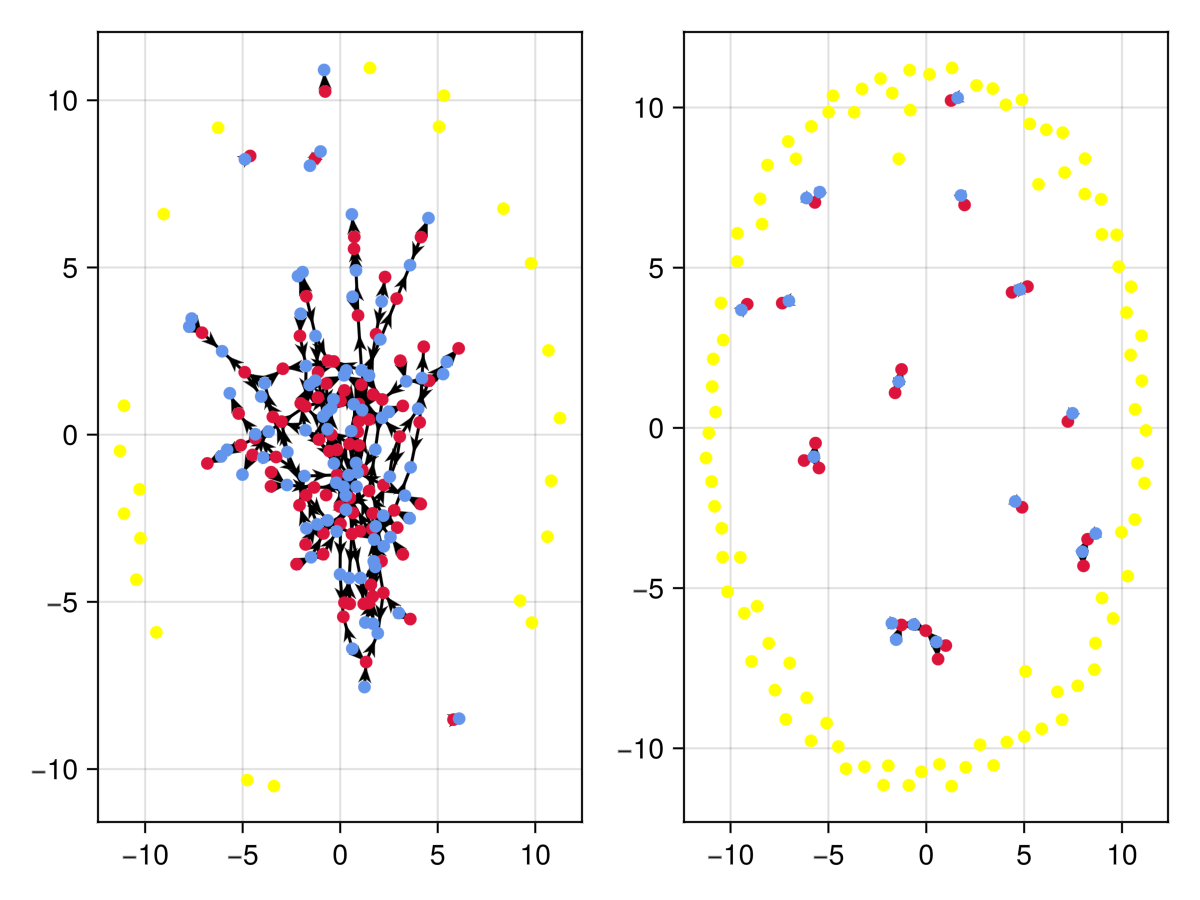

In [215]:
nc = fill(:cornflowerblue, N+M)
nc[1:N] .= :crimson
nc[gO_iso] .= :yellow

f,ax = graphplot(g_orginal, node_color = nc)

nc = fill(:cornflowerblue, Nn+M)
nc[1:N] .= :crimson
nc[g_iso] .= :yellow

graphplot!(Axis(f[1,2]), g, node_color = nc)

f

In [282]:
N,M = 2,3
λ = 1

pb = λ / (N)
pc = λ / (M)

# requirement links
B = rand(M,N) .< pb
Bl = Vector{Pair{Int,Int}}(undef, sum(B))
# production links
C = rand(N,M) .< pc
Cl = Vector{Pair{Int,Int}}(undef, sum(C))

A = [zeros(N,N) B' ; C' zeros(M,M)]

g1 = DiGraph(A)



{5, 7} directed simple Int64 graph

In [283]:
#create sparse representation
    kb,kc = 1,1
    for i = 1:N
        for j = 1:M
            if B[j,i] == 1 # if i needs j
                Bl[kb] = (i => (j + N))
                kb += 1
            end
    
            if C[i,j] == 1 # if j made by j
                Cl[kc] = ((j + N) => i)
                kc += 1
            end
    
        end
    end

    E = vcat(Bl,Cl)
    V = collect(1:(N+M))

    g = DiGraph()

    add_vertices!(g, N+M)
    [add_edge!(g, i, j) for (i,j) = E];

g

{5, 7} directed simple Int64 graph

In [332]:
function generate_web(N,M,λb,λc)
    pb = λb / (N)
    pc = λc / (M)
    
    # requirement links
    B = rand(M,N) .< pb
    # production links
    C = rand(N,M) .< pc

    A = [zeros(N,N) B'; C' zeros(M,M)]
    
    return(DiGraph(A))
end

generate_web (generic function with 1 method)

In [ ]:
function incr_web!(g, M)
    Nn = nv(g) - M
    dN = 1
    while dN > 0
        k = indegree(g)
        kb = k[1:Nn]
        kc = k[Nn+1 : end]
        
        # # #get zero degree resources
        kc0 = findall(kc .== 0)
        # println(length(kc0))
        
        # # #get consumer neighbours
        rm = vcat(neighbors.(Ref(g), kc0)...)

        if !isempty(rm)        
            rem_vertices!(g, rm)
        end

        
        dN = Nn - (nv(g) - M)
        Nn = nv(g) - M
    end
end


In [380]:
function prune_web!(g, M)
    Nn = nv(g) - M
    dN = 1
    while dN > 0
        k = indegree(g)
        kb = k[1:Nn]
        kc = k[Nn+1 : end]
        
        # # #get zero degree resources
        kc0 = findall(kc .== 0)
        # println(length(kc0))
        
        # # #get consumer neighbours
        rm = vcat(neighbors.(Ref(g), kc0)...)

        if !isempty(rm)        
            rem_vertices!(g, rm)
        end

        
        dN = Nn - (nv(g) - M)
        Nn = nv(g) - M
    end
end

function isolated!(g)
    findall(degree(g) .== 0)
end    

isolated! (generic function with 1 method)

In [ ]:
N = 100
M = 100

k = 100
λ = range(0.01,5,length = k)

Nrep = 10
p = zeros(k,k,Nrep)
v = [0]
Threads.@threads for i = eachindex(λ)
    v[1] += 1
    print("\r", v[1])
    for j = eachindex(λ)
        for r = 1:Nrep
            g = generate_web(N,M,λ[i],λ[j])
            prune_web!(g, M)
            p[i,j,r] = nv(g) / (N+M)
        end
    end
end

# heatmap(p)

In [ ]:
heatmap(λ,λ,mean(p, dims = 3)[:,:,1])

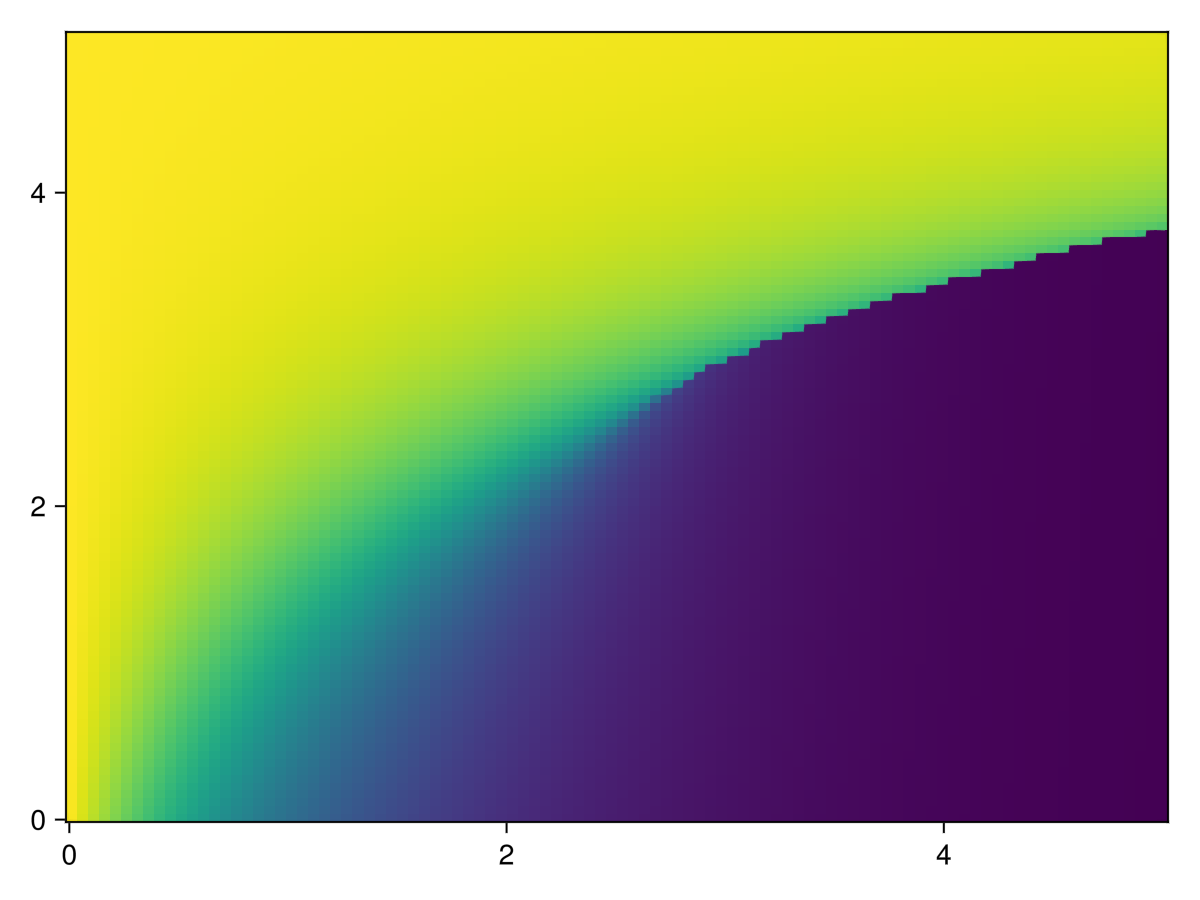

In [404]:
b = [length(b) == 1 ? b[1] : b[3] for b = b_mat]

heatmap(λb_vec, λc_vec, b)

In [139]:
f = Figure(size = (1000,250))

b_mat = map(x -> filter(y -> y != -1, x), b_mat)

b_mat_l = length.(b_mat)
heatmap!(Axis(f[1,1]), λb_vec, λc_vec, b_mat_l,  colorrange = (1,4))

b_mat_1 = map(x -> length(x) == 3 ?  x[3] : x[1], b_mat)
ax = Axis(f[1,2])
heatmap!(ax, λb_vec, λc_vec, b_mat_1, colorrange = (0,1))

b_mat_2 = map(x -> length(x) > 1 ?  x[2] : 0, b_mat)
heatmap!(Axis(f[1,3]), λb_vec, λc_vec, b_mat_2,  colorrange = (0,1))

b_mat_3 = map(x -> length(x) > 2 ?  x[1] : 0, b_mat)
heatmap!(Axis(f[1,4]), λb_vec, λc_vec, b_mat_3,  colorrange = (0,1))

# c_mat_1 = map(x -> length(x) == 3 ?  x[3] : x[1], c_mat)
# c_mat_2 = map(x -> length(x) > 1 ?  x[2] : 0, c_mat)
# c_mat_3 = map(x -> length(x) > 2 ?  x[1] : 0, c_mat)

f

In [ ]:
save("../Results/Figures/phase.png",f)

In [ ]:
f = Figure(size = (300,300))

ind = 16
thresh = 5e-6
ax = Axis(f[1,1], xlabel = "λb", ylabel = "b")

ind_x = b_mat_1[:,ind] .> 1e-2
lines!(ax, λb_vec[ind_x], b_mat_1[ind_x,ind], color = :black)

ind_x = b_mat_2[:,ind] .> 0
lines!(ax, λb_vec[ind_x], b_mat_2[ind_x,ind], linestyle = :dot, color = :black)

ind_x = findfirst(b_mat_3[:,ind] .> 0)
lines!(ax, λb_vec[ind_x:end], b_mat_3[ind_x:end,ind], color = :black)

f

In [ ]:
save("../Results/Figures/PhaseTrans.png", f)

# Exponential Graph

In [349]:
F(λ,x) = (1 - exp(-λ)) / (1 - x*exp(-λ))

fexp(λb,λc, b) = F.(λb, 1 .- F.(λc, 1 .- b)) .- b

function quadratic(a, b, c)
          discr = b^2 - 4*a*c
          discr >= 0 ? (-b - sqrt(discr))/(2a) : error("Only complex roots")
end

function fquad(λb, λc, x)
    b = exp(-λb)
    c = exp(-λc)
    
    v = @. x^2 * (c*b - c) + x * (2c - c*b - 1) + (c-1)*(b-1)
    
    return(v)
end

function onesol(λb, λc)
    b = exp(-λb)
    c = exp(-λc)
    
    a_ = b*c - c
    b_ = 2c - b*c - 1
    c_ = (b-1)*(c-1)

    v = quadratic(a_, b_, c_)
    
    return(v)
end

fig = Figure()
ax = Axis(fig[1,1])

sg = SliderGrid(
    fig[2, 1],
    (label = L"λ_b", range = 0.0:1e-6:3, format = "{:.1f}", startvalue = exp(1)),
    (label = L"λ_c", range = 0.0:1e-6:3, format = "{:.1f}", startvalue = exp(1)),
    width = 350,
    tellwidth = false)

sobs = [s.value for s in sg.sliders]

x_vec = range(-2,2,length = 100)

vals = lift(sobs...) do y...
    fexp(y..., x_vec)
end

qvals = lift(sobs...) do y...
    fquad(y..., x_vec)
end

vals2 = lift(sobs...) do y...
    onesol(y...)
end

lines!(ax, x_vec, vals)
lines!(ax, x_vec, qvals)
vlines!(ax,vals2)

ylims!(ax, -1, 1)

display(fig)

GLMakie.Screen(...)

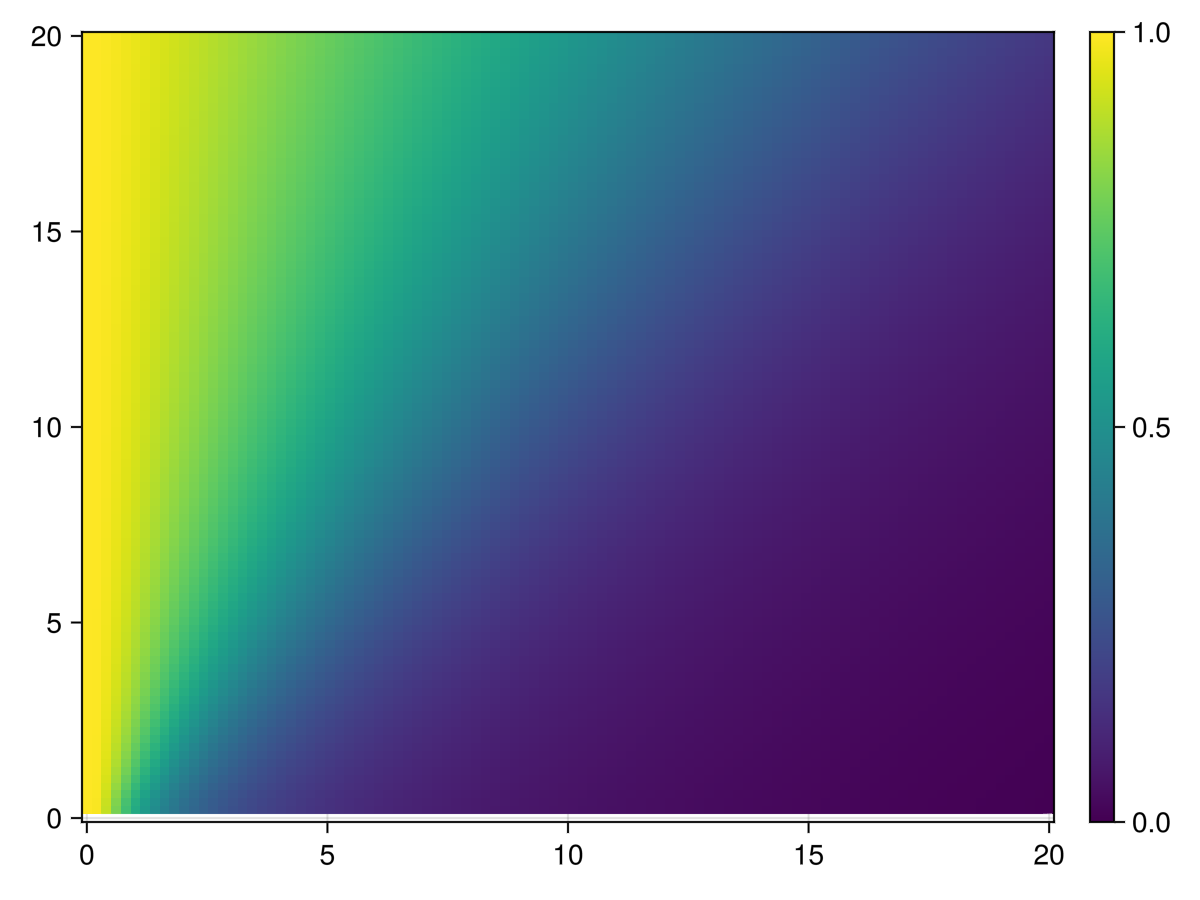

In [358]:
Nval = 1000
λb_vec = range(0.0, 20, length = N_val)
λc_vec = range(0.0, 20, length = N_val)

Δmat = [onesol(1 / λb_vec[i], 1 / λc_vec[j]) for i = 1:N_val, j = 1:N_val]

f = Figure()
ax = Axis(f[1,1])
heatmap!(ax, λb_vec, λc_vec,   Δmat, colormap = :viridis)
Colorbar(f[1,2], colorrange = (0,1))
# lines!(ax, λb_vec, (λb_vec .- 1) ./ λb_vec)
f

In [ ]:
# Simulations

N = 500
M = 500

pb = 1.0 / N
pc = 1.0 / M

B = rand(N,M) .< pb
C = rand(N,M) .< pc

A = zeros(N + M, N + M)
A[1:N, N + 1 : end] .= B
A[(N + 1) : end, 1:N] .= C'

heatmap(A)

In [365]:
A

10000×10000 Matrix{Float64}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0 

In [ ]:
pk = sum(B,dims=2)[:]
# id = unique(pk) |> sort
# pk = [sum(pk .== i) for i = id] ./ sum(pk)

#theoretical
dB = Binomial(Nc, pb)
xrange = 0:maximum(pk)
pB = pdf.(dB, xrange)

f = Figure()
ax = Axis(f[1,1])
hist!(ax, pk, normalization = :pdf)
plot!(ax, xrange, pB)
f

In [640]:

function get_b_ind(B, c_ind)
    findall( [in.(findall(B[i,:]), Ref(c_ind)) |> all  for i = 1:Nb] )
end

function get_c_ind(C, b_ind)
    findall( [in.(findall(C[:,a]), Ref(b_ind)) |> all  for a = 1:Nc] )
end

#total requirement numbers
t_b = sum(B, dims = 2)[:]
t_c = sum(C, dims = 1)[:]

b_ind = findall(t_b .== 0) #consumers with no requirement
c_ind = findall(t_c .== 0); #resources with no requirement;

print(length(b_ind), "  ", length(c_ind))

2  1

In [641]:
b_ind_ = []
c_ind_ = []

while (b_ind != b_ind_) & (c_ind != c_ind_)
    b_ind_ = deepcopy(b_ind)
    c_ind_ = deepcopy(c_ind)
    
    b_ind = get_b_ind(B,c_ind)
    c_ind = get_c_ind(C,b_ind)
end

print(length(b_ind), "  ", length(c_ind))

2  1

In [642]:
print(length(b_ind) / Nb, "  ", length(c_ind) / Nc)

0.02  0.01

In [643]:
#model prediction
fB(x) = f_pois(x,Nb * pb)
fC(x) = f_pois(x,Nc * pc)

f_opt(b) = fb(b, fB, fC) - b
z = [bisection(f_opt, x_vec[i], x_vec[i+1], 1e-6) for i = 1:Npoints-1]

filter(x -> x != -1, z)

3-element Vector{Real}:
 0.008246866861979167
 0.2653460184733073
 0.9596102396647137

In [644]:
A = zeros(Nb + Nc, Nb + Nc)
A[1:Nb, Nb + 1 : end] .= B
A[(Nb + 1) : end, 1:Nb] .= C'

con1 = findall(sum(A,dims=1)[:] .!= 0)
con2 = findall(sum(A,dims=2)[:] .!= 0)
ind = union(con1,con2)
# A = A[union(con1,con2), union(con1,con2)];

┌ Warning: Since there are a lot of edges (989 > 500), they will be drawn as straight lines even though they contain curvy edges. If you really want to plot them as bezier curves pass `edge_plottype=:beziersegments` explicitly. This will have much worse performance!
└ @ GraphMakie ~/.julia/packages/GraphMakie/W0Ok6/src/recipes.jl:545


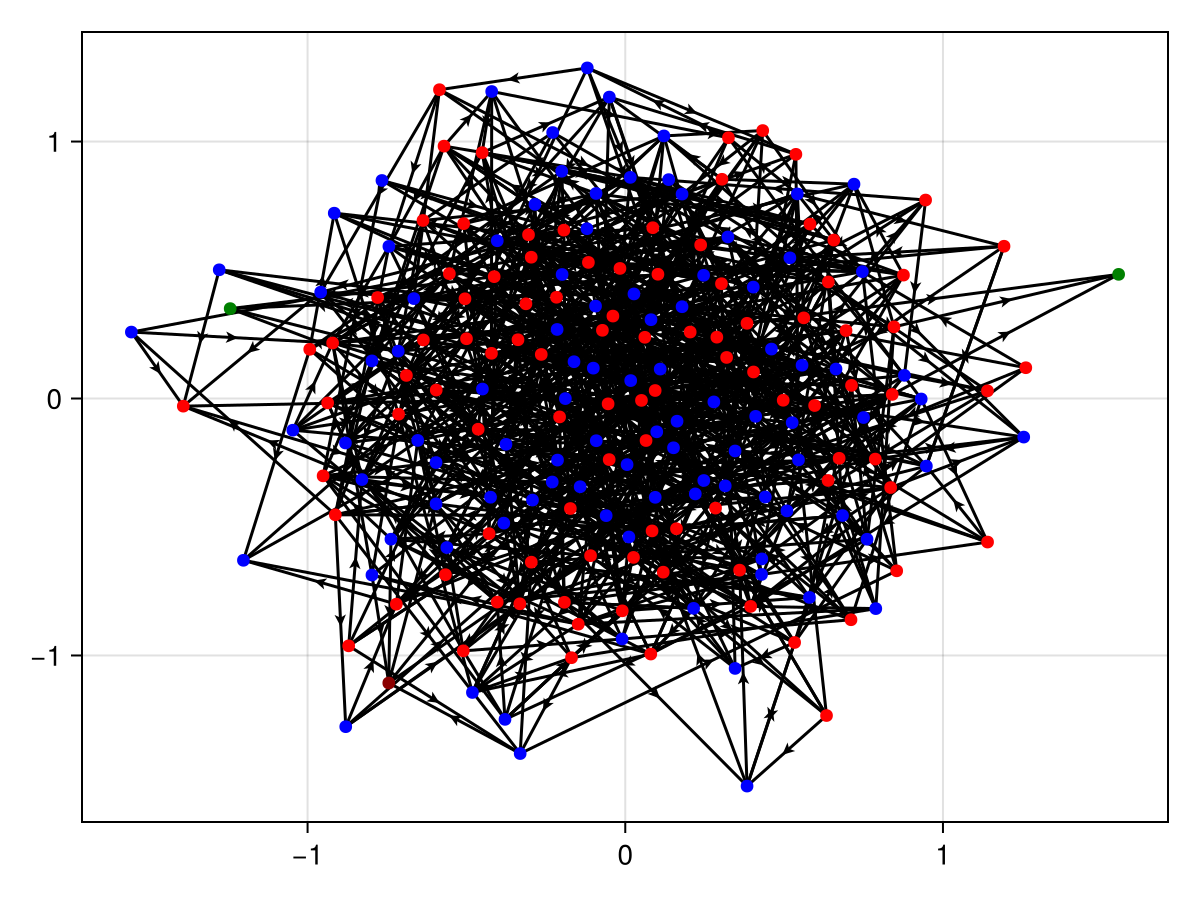

In [645]:
g = SimpleDiGraph(A[ind,ind])
c = [:red for i = 1:(Nb + Nc)]
c[1:Nb] .= :blue

c[b_ind] .= :green
c[Nb .+ c_ind] .= :darkred

graphplot(g, node_color = c[ind],  layout = Spring())

# External Supply

In [6]:
#functions
f_pois(x,p) = exp(-p*(1 - x))

fSb(x, sb) = sb + (1 - sb) * x
fSc(x, sc) = sc + (1 - sc) * x


fSc (generic function with 1 method)

In [10]:
N_val = 50
N_s = 50
Npoints = 25

#param ranges
λb_vec = range(1.0,20.0, length = N_val)
λc_vec = range(1.0,30.0, length = N_val )

sb_vec = range(0,1, length = N_s)
sc_vec = range(0,1, length = N_s)

x_vec = range(-0.0,1.1,length = Npoints)

#results
b_mat = Array{Vector{Float64}, 4}(undef, N_val, N_val, N_s, N_s)
c_mat = similar(b_mat)
val = similar(b_mat)

k = [0]
Threads.@threads for i = eachindex(λb_vec)
    k[1] += 1
    print("\r", k)
    for j = eachindex(λc_vec)
        for a = eachindex(sb_vec)
            for b = eachindex(sc_vec)
                fB(x) = fSb(f_pois(x,λb_vec[i]), sb_vec[a])
                fC(x) = fSc(f_pois(x,λc_vec[j]), sc_vec[b])


                f_opt(b) = fb(b, fB, fC) - b
            
                zeros = [bisection(f_opt, x_vec[i], x_vec[i+1], 1e-6) for i = 1:Npoints-1]

                b_mat[i,j,a,b] = zeros
                # c_mat[i,j,a,b] = fc.(filter(x -> x != -1, zeros), fB_pois, Ref(p))
            end
        end
    end
end


[50]

In [14]:
f = Figure(size = (1000,250))

b_mat = map(x -> filter(y -> y != -1, x), b_mat)

50×50×50×50 Array{Vector{Float64}, 4}:
[:, :, 1, 1] =
 [0.567143]    [0.732142]    [0.857495]    …  [1.0]
 [0.391245]    [0.572357]    [0.774215]       [1.0]
 [0.251353]    [0.3781]      [0.652258]       [1.0]
 [0.157566]    [0.215375]    [0.426]          [1.0]
 [0.0992645]   [0.12262]     [0.176138]       [1.0]
 [0.0634041]   [0.0730972]   [0.0889028]   …  [1.0]
 [0.0410609]   [0.0452627]   [0.0509974]      [1.0]
 [0.0268974]   [0.0287829]   [0.0311048]      [1.0]
 [0.0177778]   [0.0186478]   [0.0196493]      [1.0]
 [0.0118318]   [0.0122388]   [0.0126878]      [1.0]
 [0.00791397]  [0.00810699]  [0.00831401]  …  [1.0]
 [0.00531375]  [0.00540606]  [0.00550257]     [1.0]
 [0.00357793]  [0.00362269]  [0.00366885]     [1.0]
 ⋮                                         ⋱  
 [6.99361e-7]  [6.99361e-7]  [6.99361e-7]     [6.99361e-7, 0.0567238, 1.0]
 [6.99361e-7]  [6.99361e-7]  [6.99361e-7]     [6.99361e-7, 0.0577428, 1.0]
 [6.99361e-7]  [6.99361e-7]  [6.99361e-7]  …  [6.99361e-7, 0.0587344, 1.0

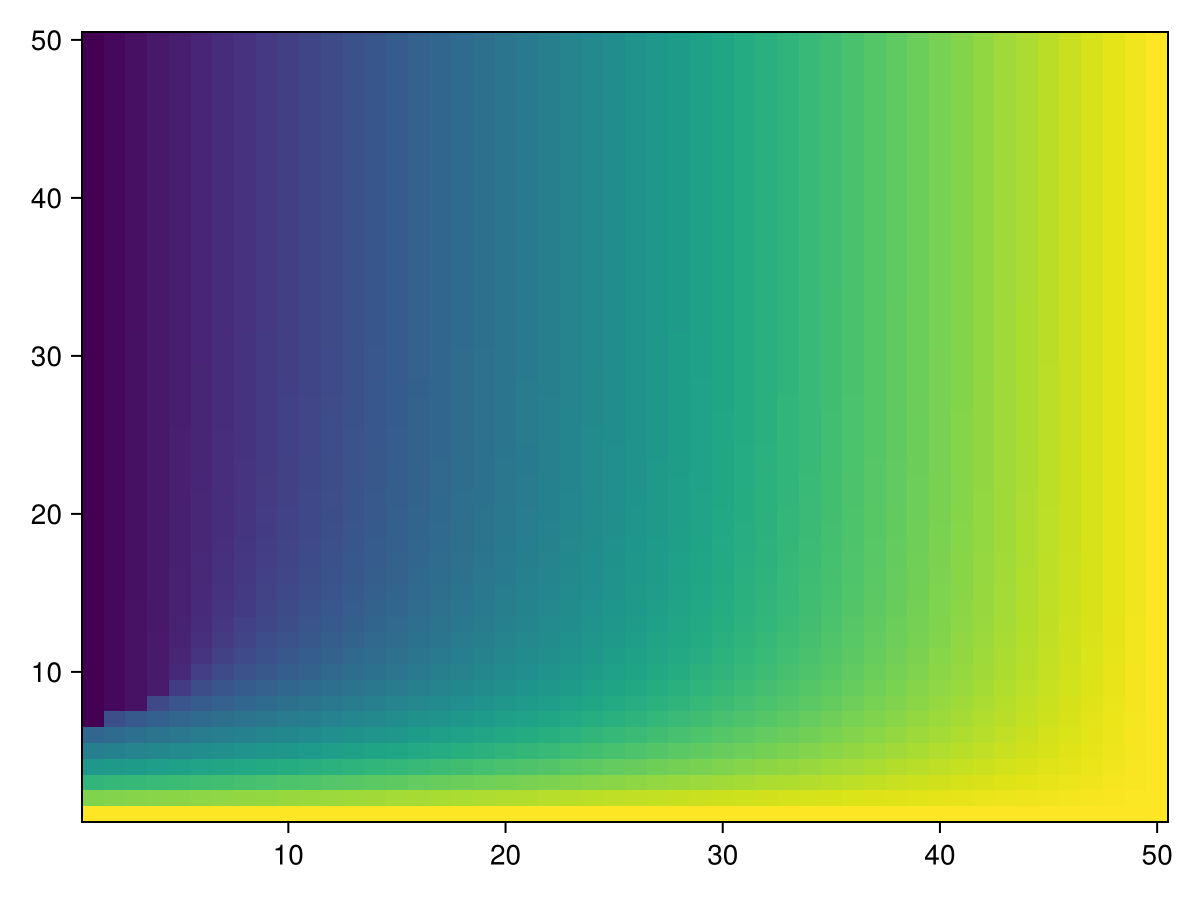

In [34]:
[maximum(b) for b = b_mat[25,25,:,:]] |> plot

# Surviving Degree Distribution

what is the degree distribution in the surviving portion of the community?

In [8]:
i = 50
j = 50

b = b_mat_1[i,j]
c = c_mat_1[i,j]

p = [λb_vec[i], λc_vec[j]]

P(x) = fB_pois(c * x, p) / fB_pois(c,p)
Q(x) = (fC_pois(x,p) - fC_pois(x*(1-b),p)) / (1 - fC_pois(1-b,p))

LoadError: UndefVarError: `c_mat_1` not defined

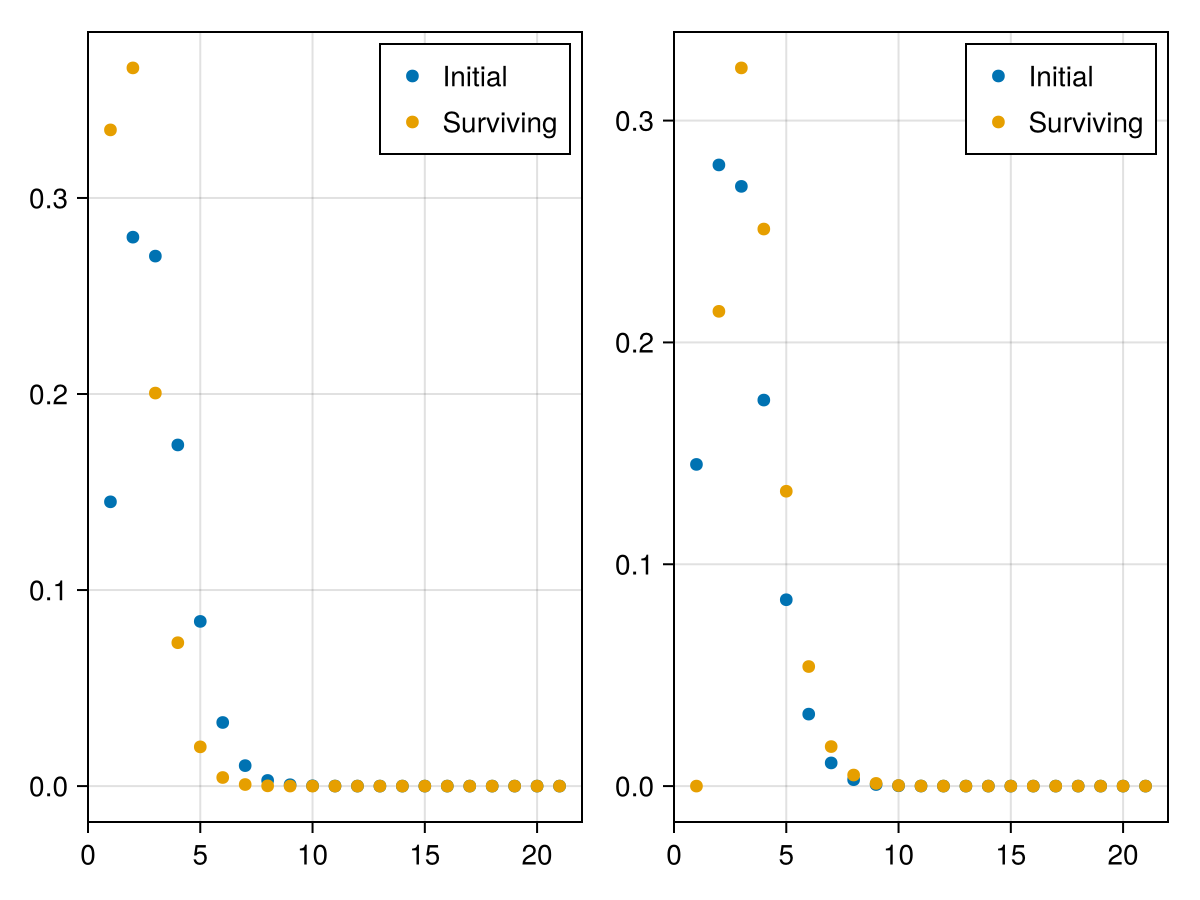

In [162]:
g(x) = fB_pois(x,p)
h(x) = fC_pois(x,p)

t = Taylor1(20)

bk = g(t).coeffs 
pk = P(t).coeffs

f,ax = plot(bk, label = "Initial")
plot!(pk, label = "Surviving")
axislegend(ax)

ck = h(t).coeffs
qk = Q(t).coeffs

ax = Axis(f[1,2])
plot!(ax, ck, label = "Initial")
plot!(ax, qk, label = "Surviving")
axislegend(ax)

f

How do interactions change when considering the surviving proportion?

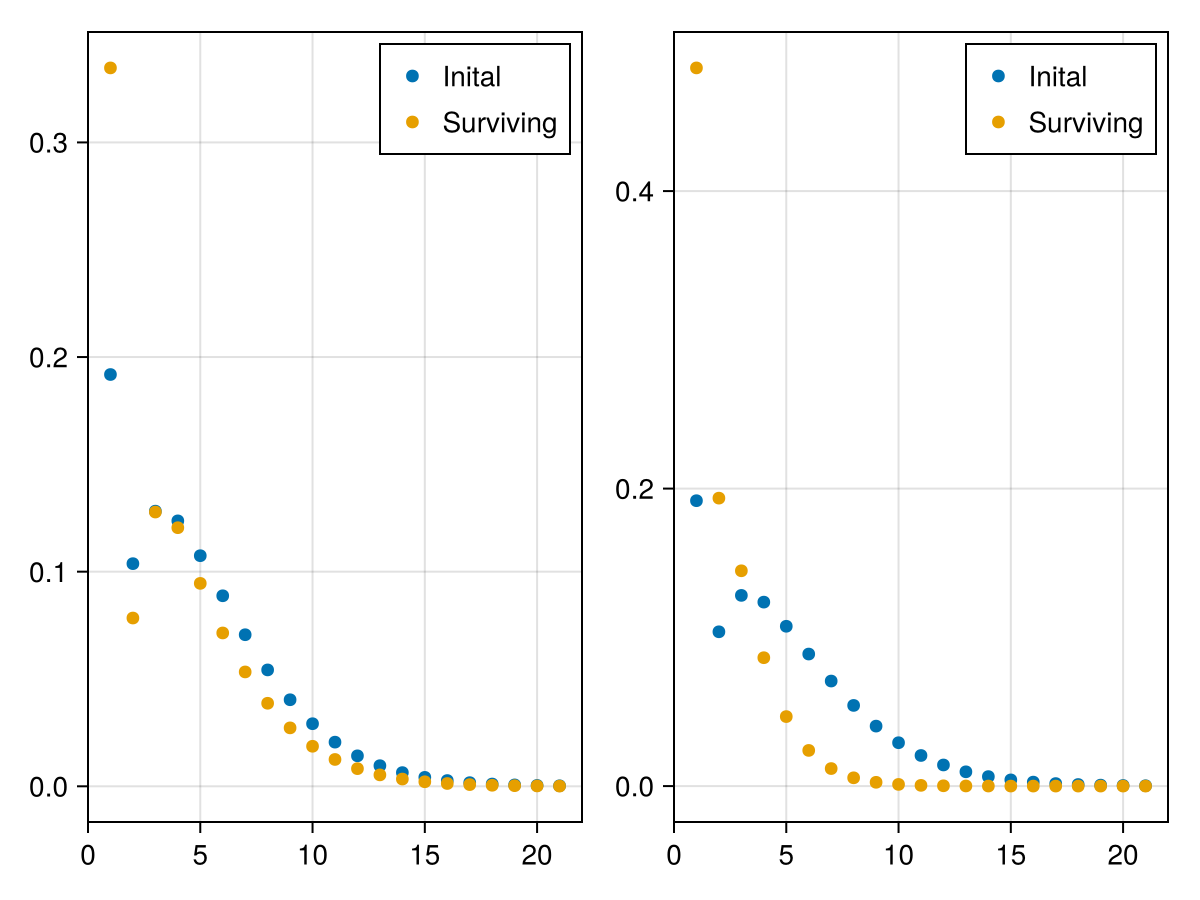

In [163]:
I(x) = g(h(x))
J(x) = P(Q(x))

fac_i = I(t).coeffs
fac_s = J(t).coeffs


f,ax = plot(fac_i, label = "Inital")
plot!(ax, fac_s, label = "Surviving")
axislegend(ax)

I(x) = g(g(x))
J(x) = P(P(x))

comp_i = I(t).coeffs
comp_s = J(t).coeffs

ax = Axis(f[1,2])
plot!(ax, comp_i, label = "Inital")
plot!(ax, comp_s, label = "Surviving")
axislegend(ax)

f

# resource and consumer supply


In [ ]:
fB_pois(x,p) = exp(-p[1]*(1 - x))
fC_pois(x,p) = exp(-p[2]*(1 - x))

fc(b, fC, p) = (1 - fC(1-b[1], p)) * p[3]
fb(b, fB, fC, p) = fB(fc(b,fC,p) * p[4] ,p)


p = [4.0, 5.0, 1.0, 1.0]
fb(0.5, fB_pois, fC_pois, p)

In [30]:
N_val = 10
Npoints = 100
Np = 100

#param ranges
λb_vec = range(1.0,20.0, length = N_val)
λc_vec = range(1.0,20.0, length = N_val)
x_vec = range(-0.0,1.1,length = Npoints)
p_vec = 1 .- exp.(range(-5.0, 0.0,length = Np))
q_vec = 1 .- exp.(range(-5.0, 0.0,length = Np))

#results
b_mat = Array{Vector{Float64}, 4}(undef, N_val,N_val, Np, Np)
c_mat = similar(b_mat)
val = similar(b_mat)

k = [0]
Threads.@threads for i = eachindex(λb_vec)
    k[1] += 1
    print("\r", k)
    for j = eachindex(λc_vec)
        for n = eachindex(p_vec)
            for m = eachindex(q_vec)
                p = [λb_vec[i], λc_vec[j], p_vec[n], q_vec[m]]
                f_opt(b) = fb(b, fB_pois, fC_pois, p) - b
                
                zeros = [bisection(f_opt, x_vec[i], x_vec[i+1], 1e-6) for i = 1:Npoints-1]
    
                b_mat[i,j,n,m] = zeros
                c_mat[i,j,n,m] = fc.(filter(x -> x != -1, zeros), fB_pois, Ref(p))
            end
        end
    end
end


[10]

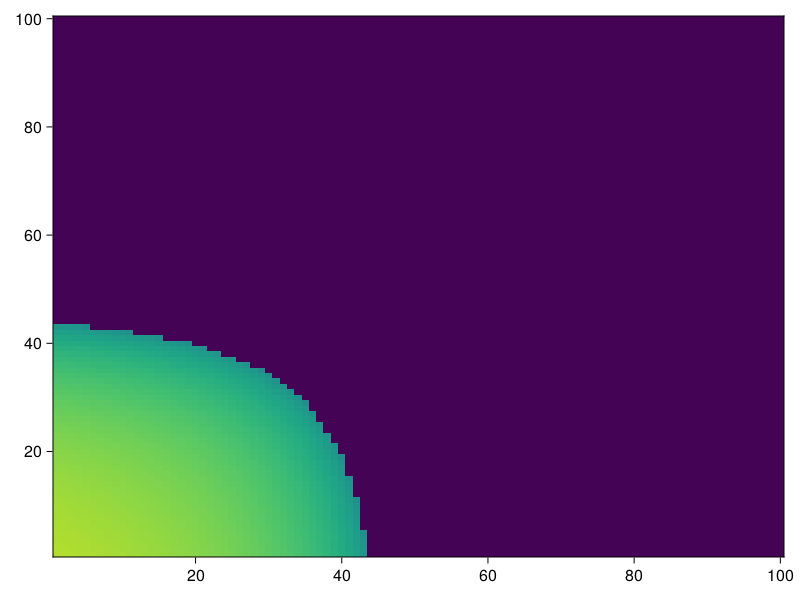

In [37]:
f = Figure(resolution = (1000,1000))

b_mat = map(x -> filter(y -> y != -1, x), b_mat)

heatmap(maximum.(b_mat)[3,3,:,:], colorrange = (0,1))


In [18]:
plot(1 - p_vec)

LoadError: MethodError: no method matching -(::Int64, ::Vector{Float64})
For element-wise subtraction, use broadcasting with dot syntax: scalar .- array

[0mClosest candidates are:
[0m  -([91m::ChainRulesCore.NotImplemented[39m, ::Any)
[0m[90m   @[39m [35mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/PvTbU/src/[39m[90m[4mtangent_arithmetic.jl:49[24m[39m
[0m  -(::Any, [91m::MutableArithmetics.Zero[39m)
[0m[90m   @[39m [36mMutableArithmetics[39m [90m~/.julia/packages/MutableArithmetics/NIXlP/src/[39m[90m[4mrewrite.jl:64[24m[39m
[0m  -([91m::ChainRulesCore.NoTangent[39m, ::Any)
[0m[90m   @[39m [35mChainRulesCore[39m [90m~/.julia/packages/ChainRulesCore/PvTbU/src/[39m[90m[4mtangent_arithmetic.jl:61[24m[39m
[0m  ...


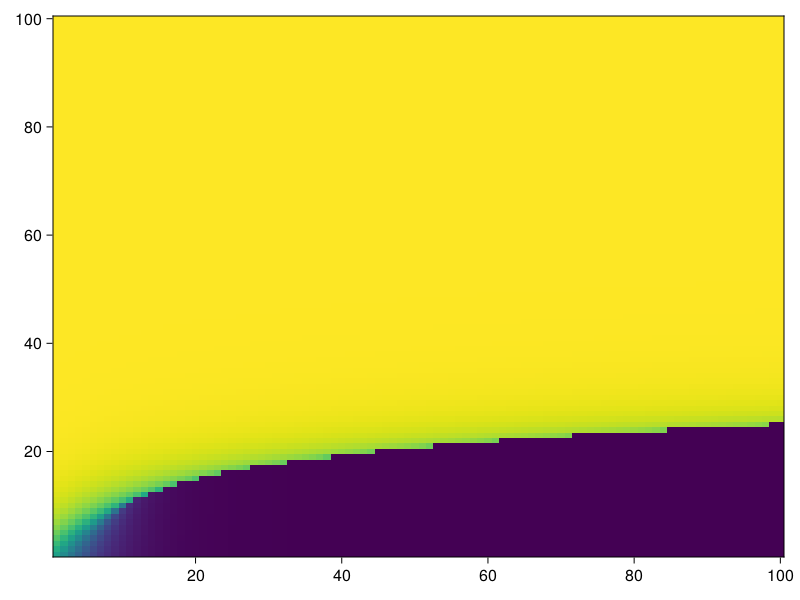

In [30]:
b_mat_1 = map(x -> length(x) == 3 ?  x[3] : x[1], b_mat)
b_mat_1[:,:,1,1] |> heatmap

# interactive plot

In [729]:
using GLMakie

x = -1.0:0.01:1.0
func(a,b) = exp.(-a .* exp.(-b .* x)) .- x
dfunc(a,b) = a .* b .* exp.(-a .* exp.(-b .* x) .- (x .* b) ) .- 1
dfunc2(a,b) = a .* b .* b .* -exp.(-a .* exp.(-b .* x) .- (2 .* x .* b) ) .* (exp.(x .* b) .- a) .* 0.2

func2(a,b,x) = exp(-a * exp(-b * x)) - x

fig = Figure(size = (1000, 1000))

ax = Axis(fig[1, 1])

sg = SliderGrid(
    fig[2, 1],
    (label = L"λ_b", range = exp(1):0.001:100, format = "{:.1f}", startvalue = exp(1)),
    (label = L"λ_c", range = exp(1):0.001:100, format = "{:.1f}", startvalue = exp(1)),
    width = 350,
    tellwidth = false)

sobs = [s.value for s in sg.sliders]

vals = lift(sobs...) do y...
    func([y...]...)
end

dvals = lift(sobs...) do y...
    dfunc([y...]...)
end

d2vals = lift(sobs...) do y...
    dfunc2([y...]...)
end

guess_v = lift(sobs...) do y...
    log(y[1]) / y[2]
end

guess_h = lift(sobs...) do y...
    (y[2] * exp(-1)) - 1
end

b1 = lift(sobs...) do y...
    (lambertw(-1/y[2], 0) - log(1 / (y[1]*y[2]))) / y[2]
end

b2 = lift(sobs...) do y...
    (lambertw(-1/y[2], -1) - log(1 / (y[1]*y[2]))) / y[2]
end

f1 = lift([sobs...,b1]...) do y...
    W = lambertw(-1/y[2], 0)
    l = log(1 / (y[1]*y[2]))
    return( ((W*l) - (W^2) - 1) / (W * y[2]) )
end

f2 = lift([sobs...,b2]...) do y...
    W = lambertw(-1/y[2], -1)
    l = log(1 / (y[1]*y[2]))
    return( ((W*l) - (W^2) - 1) / (W * y[2]) )
end


lines!(ax, x, vals, label = "f(b)")
lines!(ax, x, dvals, label = "f'(b)")
lines!(ax, x, d2vals, label = "f''(b)")

# vlines!(ax, guess_v, color = (:red, 0.2))
# hlines!(ax, guess_h, color = (:red, 0.2))

vlines!(ax, b1, color = (:red, 0.2), label = L"W_0")
vlines!(ax, b2, color = (:green, 0.2), label = L"W_{-1}")

scatter!(ax, b1, f1, color = (:red, 0.8))
scatter!(ax, b2, f2, color = (:green, 0.8))


vlines!(ax, [0.0], color = :black, linestyle = :dash)
hlines!(ax,[0.0], color = :black, linestyle = :dot)

axislegend(ax)

display(fig)

GLMakie.Screen(...)

In [755]:
using GLMakie

F(X,Y,λ) = exp(λ[1]*(X − 1) + λ[2]*(Y − 1) + λ[3]*(X*Y − 1))
B1_I(X,λ) = (λ[2] + λ[3] * X) * exp((λ[1] + λ[3]) * (X-1)) / (λ[2] + λ[3]) #Excess In degree
C1_I(X,λ) = (λ[1] + λ[3] * X) * exp((λ[2] + λ[3]) * (X-1)) / (λ[1] + λ[3]) #Excess In degree

fb1(b_1, λ) = (λ[2] + λ[3]) * F1_I( (λ[1] + λ[3]) * (1 - C1_I(b_1,λ)), λ) - b_1

fig = Figure(size = (1000, 1000))
ax = Axis(fig[1, 1])

sg = SliderGrid(
    fig[2, 1],
    (label = L"λ_n", range = 0.0:0.001:5, format = "{:.1f}", startvalue = 1),
    (label = L"λ_p", range = 0.0:0.001:5, format = "{:.1f}", startvalue = 1),
    (label = L"λ_r", range = 0.0:0.001:5, format = "{:.1f}", startvalue = 1),
    width = 350,
    tellwidth = false)

sobs = [s.value for s in sg.sliders]

x = -1.0:0.01:1.0

vals = lift(sobs...) do y...
    fb1.(x ,Ref([y...]))
end



lines!(ax, x, vals, label = "f(b)")
ylims!(-10,10)
display(fig)

GLMakie.Screen(...)

2024-08-05 21:32:02.770 julia[14359:232655] AdjustToIronwoodHotKeyChange - CG (hotmod:1) HotKey : hotKey enabled = 1, keyChar=0xfffbffff, virtKey=0x40000, flags=0x0 
2024-08-06 07:45:55.562 julia[14359:232655] AdjustToIronwoodHotKeyChange - CG (hotmod:1) HotKey : hotKey enabled = 1, keyChar=0xfffbffff, virtKey=0x40000, flags=0x0 


In [51]:
λb = 5.0
λc = 5.0

x = -1/λc
b = (lambertw(x, -1) - log(1 / (λb * λc))) / λc

exp(-λb * exp(-λc * b))

0.07865836028685172

In [57]:
W = lambertw(x, -1)
l = log(1 / (λb * λc))

-3.2188758248682006

In [66]:
exp(W^2)

642.280467951838

In [72]:
1 / (exp(1) / exp(W))

0.028936793625789